In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
# from himalaya.ridge import RidgeCV
import numpy as np
from pathlib import Path
from AOTaccess.stimulus_info_access import StimuliInfoAccess
from AOTaccess.glmsingle_access import GLMSingleAccess

from himalaya.backend import set_backend

backend = set_backend("numpy", on_error="warn")

from AOTanalysis.bandedRR.utils import (
    reshape_from_flatten_masked_to_wholebrain,
)
from AOTanalysis.voxelsemantic.corpus_construct import construct_AOT_corpus
import joblib
import pickle
from pprint import pprint

import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nibabel import Nifti1Image
import cortex
import nibabel as nib
import os
opj = os.path.join

from matplotlib.colors import Normalize
def Vertex2D_fix(data1, data2, subject, cmap, vmin, vmax, vmin2, vmax2, roi_borders=None):
    #this provides a nice workaround for pycortex opacity issues, at the cost of interactivity    
    # Get curvature
    curv = cortex.db.get_surfinfo(subject)
    # Adjust curvature contrast / color
    curv.data = curv.data * .75 +0.1
    curv = cortex.Vertex(curv.data, subject, vmin=-1,vmax=1,cmap='gray')
    norm2 = Normalize(vmin2, vmax2)   
    vx = cortex.Vertex(data1, subject, cmap=cmap, vmin=vmin, vmax=vmax)
    # Map to RGB
    vx_rgb = np.vstack([vx.raw.red.data, vx.raw.green.data, vx.raw.blue.data])
    curv_rgb = np.vstack([curv.raw.red.data, curv.raw.green.data, curv.raw.blue.data])
    # Alpha mask
    alpha = np.clip(norm2(data2), 0, 1)
    display_data = (curv_rgb * (1-alpha)) + vx_rgb * alpha
    display_data /= 255
    if roi_borders is not None:
        display_data[:,roi_borders.astype('bool')] = 0
    
    # Create vertex RGB object out of R, G, B channels
    return cortex.VertexRGB(*display_data, subject) 


backend = set_backend("numpy", on_error="warn")

In [6]:
sub = 1
#model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_session_testinside2/model_sub{sub}_feature_motion32_trainses_1_Xcentered_True_Yzscore_True_Xstd_True_testinside.joblib"
model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_multiple_session_based/model_sub{sub}_feature_motion_trainses_1_2_3.joblib"
#model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_multiple_session_based/model_sub{sub}_feature_motion_trainses_1.joblib"
model = joblib.load(model_path)
cx_sub = f'sub-{sub:03d}'
deriv_dir = '/tank/shared/2024/visual/AOT/derivatives/'
param_path_dir = opj(deriv_dir, "prf", cx_sub)
fs_dir = opj(deriv_dir, "freesurfer")

/tank/marcus/miniconda3/envs/aot_003/lib/python3.13/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tank/marcus/miniconda3/envs/aot_003/lib/python3.13/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
primal_coef = model[-1].get_primal_coef()
primal_coef = backend.to_numpy(primal_coef)
print("n_features, n_voxels) =", primal_coef.shape)
primal_coef = primal_coef.numpy()
max_index = np.argmax(primal_coef, axis=0)
print("max_index.shape =", max_index.shape)

n_features, n_voxels) = torch.Size([11845, 336275])
max_index.shape = (336275,)


In [8]:
# Load the R2 scores for masking
R2_file = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_multiple_session_based/R2_score_single_sub{sub}_motion_train_1_2_3_test_4.nii.gz"
R2 = nib.load(R2_file)
R2_data = R2.get_fdata()
print("R2_data shape:", R2_data.shape)
R2_data = np.transpose(R2_data, (2, 1, 0))
print("Transposed R2_data shape:", R2_data.shape)

R2_data shape: (81, 95, 101)
Transposed R2_data shape: (101, 95, 81)


In [9]:
ses=1
glmaccess = GLMSingleAccess()
mask = glmaccess.read_R2_mask(sub, ses=ses)
shape = glmaccess.read_shape(sub, ses=ses)
voxel_num = np.prod(shape)
flatten_mask = mask.flatten()
data_reshape = np.zeros(voxel_num)
r2_flat = R2_data.flatten()[flatten_mask]
r2_flat

array([0., 0., 0., ..., 0., 0., 0.], shape=(336275,))

In [16]:
from AOTanalysis.voxelmotion.filter_info import FilterInfo
fobj = FilterInfo()



In [13]:
fobj.pyramid.definition

{'aspect_ratio': 1.7777777777777777,
 'filter_spacing': 3.5,
 'filter_temporal_width': 16,
 'filter_vht_fov': (1080, 1920, 16),
 'hdim': 1920,
 'include_edges': False,
 'max_spatial_env': 0.3,
 'max_temp_env': 0.3,
 'sf_gauss_ratio': 0.6,
 'spatial_directions': [0, 45, 90, 135, 180, 225, 270, 315],
 'spatial_frequencies': [0, 2, 4, 8, 16, 32],
 'spatial_phase_offset': 0.0,
 'stimulus_fps': 24,
 'stimulus_vhsize': (1080, 1920),
 'stimulus_vht_fov': (1080, 1920, 24),
 'temporal_frequencies': [0, 2, 4],
 'tf_gauss_ratio': 10.0,
 'vdim': 1080}

# NISHIMOTO STIM GENERATION

In [287]:
import numpy as np
from AOTanalysis.voxelmotion.filter_info import FilterInfo
class NishiStim(FilterInfo):
    def __init__(self, **kwargs):
        # Initialize with the FilterInfo class..
        super().__init__(**kwargs)
        self.stim_space = {}
        self.stim_sftf = {}
        

    def _stim_make_space(self,n_frames=24, grid_size=(17, 17), **kwargs):
        # Going to splid 
        downsample = kwargs.get('downsample', 1)
        vhsize = self.vhsize[0]//downsample, self.vhsize[1]//downsample
        print(f'Downsampled vhsize = {vhsize}')
        self.stim_space = {}
        self.stim_space['downsample'] = downsample
        self.stim_space['grid_size'] = grid_size
        self.stim_space['filt_resp'] = []
        self.stim_space['filt_resp_avg'] = []
        self.stim_space['filt_x']   = []
        self.stim_space['filt_y']   = []

        i_total = 0
        for ix in range(grid_size[0]):
            for iy in range(grid_size[1]):
                mat,pix_x,pix_y = generate_dynamic_gaussian_noise(
                    n_frames=n_frames, 
                    grid_size=grid_size, 
                    vhsize=vhsize, 
                    grid_location=[ix,iy], 
                    **kwargs,
                    )
                # convert pix_x, pix_y to fractions of height
                xdov, ydov = self._screen2dov(
                    xscr=pix_x / vhsize[0], # Divide be new screen heigh in pix
                    yscr=pix_y / vhsize[0],

                )
                self.stim_space['filt_x'].append(xdov)
                self.stim_space['filt_y'].append(ydov)
                fresp = self.pyramid.project_stimulus(mat,use_cuda=True,)
                self.stim_space['filt_resp'].append(fresp.copy())
                self.stim_space['filt_resp_avg'].append(
                    np.mean(fresp, axis=0)
                )
                
    
    def _stim_make_gray(self,n_frames=24, **kwargs):
        # Going to splid 
        downsample = kwargs.get('downsample', 1)
        vhsize = self.vhsize[0]//downsample, self.vhsize[1]//downsample
        print(f'Downsampled vhsize = {vhsize}')
        self.stim_gray = {}
        self.stim_gray['downsample'] = downsample
        mat = np.zeros((n_frames, vhsize[0], vhsize[1]), dtype=float) + 50.0
        fresp =self.pyramid.project_stimulus(mat,use_cuda=True,)
        self.stim_gray['filt_resp'] = fresp.copy()
        self.stim_gray['filt_resp_avg'] = np.mean(fresp, axis=0)        

    def _stim_make_tfsf(self, n_frames=24,  **kwargs):
        '''
        Generate full-field drifting sine-wave gratings at specified temporal
        frequency (tf), spatial frequency (sf), and orientation (dir).
        '''
        downsample = kwargs.get('downsample', 1)
        vhsize = self.vhsize[0]//downsample, self.vhsize[1]//downsample
        tf_list = kwargs.get('tf_list', self.pyramid.definition['temporal_frequencies'])
        sf_list = kwargs.get('sf_list', self.pyramid.definition['spatial_frequencies'])
        dir_list = kwargs.get('dir_list', self.pyramid.definition['spatial_directions'])
        frame_rate = kwargs.get('frame_rate', self.pyramid.definition['stimulus_fps'])
        
        print(f'Downsampled vhsize = {vhsize}')
        self.stim_tfsf = {}
        self.stim_tfsf['downsample'] = downsample
        self.stim_tfsf['tf'] = []
        self.stim_tfsf['sf'] = []
        self.stim_tfsf['dir'] = []
        self.stim_tfsf['filt_resp'] = []
        self.stim_tfsf['filt_resp_avg'] = []

        for tf in tf_list:
            for sf in sf_list:
                for dir in dir_list:
                    print(f'{tf}, {sf}, {dir}')
                    # Generate drifting grating movie
                    mat = mk_drifting_grating_movie(
                        vhsize=vhsize,
                        stimulus_fps=frame_rate,
                        aspect_ratio=self.aspect_ratio,
                        nframe=n_frames,
                        direction=dir,
                        spatial_freq=sf,
                        temporal_freq=tf,
                    )
                    self.stim_tfsf['tf'].append(tf)
                    self.stim_tfsf['sf'].append(sf)
                    self.stim_tfsf['dir'].append(dir)
                    fresp =self.pyramid.project_stimulus(mat,use_cuda=True,)
                    self.stim_tfsf['filt_resp'] = fresp.copy()
                    self.stim_tfsf['filt_resp_avg'] = np.mean(fresp, axis=0)        


In [272]:

def mk_drifting_grating_movie(vhsize,
                               stimulus_fps,
                               aspect_ratio='auto',
                               nframe=24,
                               centerh=0.5,
                               direction=45.0,
                               spatial_freq=16.0,
                               temporal_freq=2.0,
                               centerv=0.5,
                               spatial_phase_offset=0.0,
                               mean=50.0, contrast=50.0,
                               **kwargs
                               ):
    '''Make a full-field drifting sinusoidal grating movie.
    
    Adapted from     
    https://github.com/gallantlab/pymoten/blob/7570e1979744fd0950e21e581dd12e07a8cd6b1b/moten/core.py#L132

    Parameters
    ----------
    vhsize : tuple of ints, (vdim, hdim)
        Frame size in pixels: (vertical, horizontal).
    stimulus_fps : float
        Playback speed (frames per second).
    aspect_ratio : 'auto' or float
        Frame width/height ratio. 'auto' sets it to hdim/vdim.
    nframe : int or 'auto'
        Number of frames. 'auto' uses one temporal period (fps/temporal_freq).
    centerh, centerv : floats in [0,1]
        Grating center in normalized coordinates (horizontal, vertical).
    direction : float [degrees]
        Drift direction (0=right, 90=up).
    spatial_freq : float
        Spatial frequency (cycles per frame width).
    temporal_freq : float
        Temporal frequency (cycles per second).
    spatial_phase_offset : float [radians]
        Initial spatial phase offset.

    Returns
    -------
    movie : ndarray, shape (nframe, vdim, hdim)
        Drifting grating frames, values in [-1,1].
    '''
    vdim, hdim = vhsize
    # aspect ratio
    if aspect_ratio == 'auto':
        aspect_ratio = hdim / float(vdim)

    nframe = int(nframe)

    # spatial coords
    dh = np.linspace(0, aspect_ratio, hdim, endpoint=True)
    dv = np.linspace(0, 1, vdim, endpoint=True)
    ihs, ivs = np.meshgrid(dh, dv)

    dt = np.arange(nframe) / stimulus_fps #np.linspace(0, 1, nframe, endpoint=False)

    # compute spatial and temporal waves
    theta = np.deg2rad(direction)
    fh = -spatial_freq * np.cos(theta) * 2 * np.pi
    fv = spatial_freq * np.sin(theta) * 2 * np.pi
    if temporal_freq == 0:
        ft = np.ones_like(temporal_freq)
    else:
        ft = temporal_freq * (1.0 / temporal_freq) * 2 * np.pi  # one cycle over dt


    spatial_arg = (ihs - centerh) * fh + (ivs - centerv) * fv + spatial_phase_offset

    # build movie
    movie = np.zeros((nframe, vdim, hdim), dtype=np.float32)
    for t in range(nframe):
        temporal_phase = dt[t] * ft
        movie[t] = mean + contrast * np.sin(spatial_arg + temporal_phase)

    return movie



In [ ]:
import numpy as np



In [279]:
a = mk_drifting_grating_movie(vhsize=(108,192),
                               stimulus_fps=24,
                               aspect_ratio='auto',
                               nframe=24,
                               centerh=0.5,
                               centerv=0.5,
                               direction=45.0,
                               spatial_freq=1.0,
                               temporal_freq=1.0,
                               spatial_phase_offset=0.0)

In [275]:
a.min()

np.float32(1.8957991e-10)

In [ ]:
ns = NishiStim()
ns._stim_make_space(grid_size=(17,17), downsample=10)
with open('./ns_space', 'wb') as f:
    pickle.dump(ns.stim_space, file=f)

ns._stim_make_gray(downsample=10)
with open('./ns_gray', 'wb') as f:
    pickle.dump(ns.stim_gray, file=f)


ns._stim_make_(downsample=10)
with open('./ns_gray', 'wb') as f:
    pickle.dump(ns.stim_gray, file=f)


<string>:24: RuntimeWarning: divide by zero encountered in divide
<string>:24: RuntimeWarning: invalid value encountered in divide


In [269]:
ns._stim_make_gray(downsample=60)

Downsampled vhsize = (18, 32)


project_stimulus:   0%|          | 0/11845 [00:00<?, ?it/s]

project_stimulus: 100%|██████████| 11845/11845 [00:03<00:00, 3484.01it/s]


In [282]:
a = ns._stim_make_tfsf(downsample=60)

Downsampled vhsize = (18, 32)
0, 0, 0


project_stimulus:   9%|▊         | 1019/11845 [00:00<00:03, 3425.93it/s]

project_stimulus: 100%|██████████| 11845/11845 [00:03<00:00, 3431.89it/s]


AttributeError: 'NishiStim' object has no attribute 'stistim_tfsfm_gray'

In [216]:
plt.imshow(a[24,:,:], vmin=0, vmax=100)

IndexError: index 24 is out of bounds for axis 0 with size 24

In [188]:
ns.stim_space['filt_resp_avg'][0].shape

(11845,)

In [193]:
ns._stim_make_gray(downsample=40)

Downsampled vhsize = (27, 48)


project_stimulus: 100%|██████████| 11845/11845 [00:04<00:00, 2838.91it/s]


In [194]:
ns.stim_gray

{'downsample': 40}

In [154]:
with open('./nishi_spatial', 'wb') as f:
    pickle.dump( ns.stim_space, file=f)

In [285]:
with open('./nishi_spatial', 'rb') as f:
    a =pickle.load(file=f)

In [286]:
a

{'downsample': 40,
 'grid_size': (9, 5),
 'filt_resp': [array([[ 4.2911963, 11.406454 ,  3.603189 , ...,  4.2777634,  5.189082 ,
           4.305895 ],
         [ 4.466674 , 11.586844 ,  3.61656  , ...,  4.3898053,  5.1985793,
           4.417937 ],
         [ 4.6168284, 11.736572 ,  3.5638924, ...,  4.3301783,  5.1516247,
           4.3583093],
         ...,
         [ 4.7753158, 11.92861  ,  3.3149455, ...,  3.9816453,  4.9673676,
           4.009777 ],
         [ 4.6671786, 11.827161 ,  3.5095263, ...,  4.3222456,  5.1408935,
           4.350377 ],
         [ 4.537547 , 11.700456 ,  3.6194584, ...,  4.4198623,  5.244492 ,
           4.4479938]], shape=(24, 11845), dtype=float32),
  array([[ 4.2007346, 11.406376 ,  3.6296294, ...,  4.2777634,  5.189082 ,
           4.305895 ],
         [ 4.3935933, 11.586779 ,  3.6621606, ...,  4.3898053,  5.1985793,
           4.417937 ],
         [ 4.5487776, 11.73651  ,  3.650776 , ...,  4.3301783,  5.1516247,
           4.3583093],
         ...,


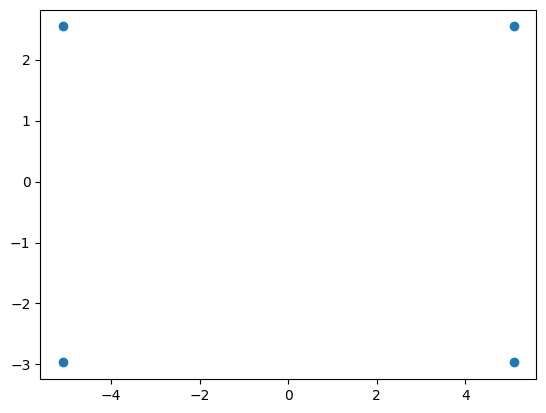

In [181]:
plt.scatter(ns.stim_space['filt_x'],ns.stim_space['filt_y'])

In [67]:
beep = ns.pyramid.project_stimulus(a[0])

project_stimulus:   0%|          | 0/11845 [00:00<?, ?it/s]

project_stimulus: 100%|██████████| 11845/11845 [00:14<00:00, 828.36it/s]


 ...]

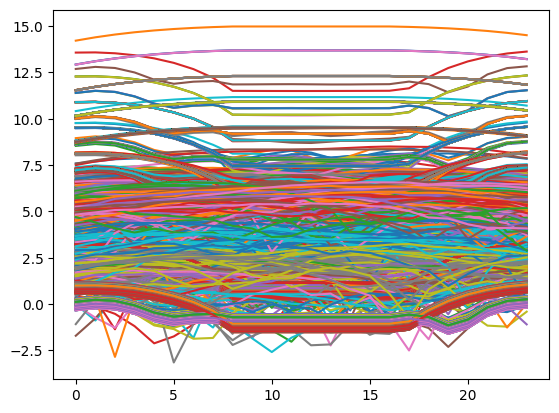

In [71]:
plt.plot(beep)

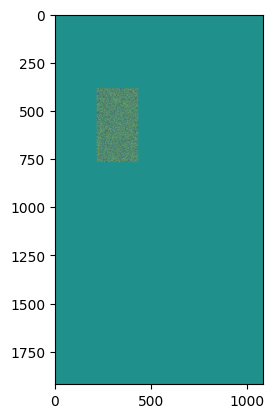

In [59]:
plt.imshow(a[0][-1,:,:],vmin=0, vmax=100)

In [40]:
a[0][10,:,:]

array([[-0.00662583,  0.48665791, -1.01641931, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.34955563, -1.88541673,  0.0444665 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.59276723, -0.67449282,  0.11619102, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], shape=(1920, 1080))

/tank/marcus/miniconda3/envs/aot_003/lib/python3.13/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


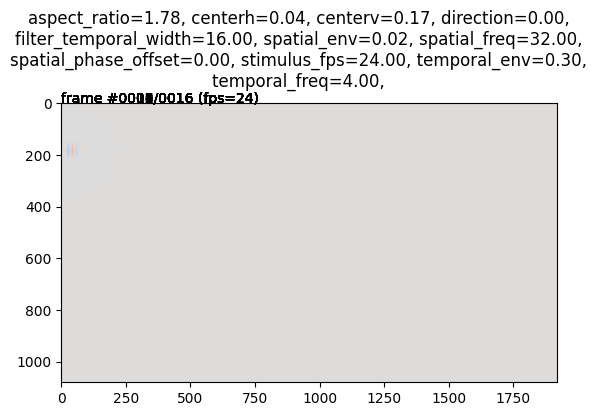

In [11]:
a = np.where(fobj.filter_df['SFimg']==32)[0][8]
fobj.pyramid.show_filter(a)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_centered_imshow(ax, img, x, y, size=(1, 1), **kwargs):
    """
    Place an image `img` on axis `ax`, centered at (x, y) with given width and height.
    Parameters:
        ax    : matplotlib axis
        img   : 2D array to display
        x, y  : center coordinates
        size  : tuple (width, height) in data units
        kwargs: additional arguments passed to ax.imshow
    """
    width, height = size
    # Compute extent so that the image is centered
    extent = (x - width / 2, x + width / 2, y - height / 2, y + height / 2)
    ax.imshow(img, extent=extent, origin='lower', **kwargs)



array([10859, 10825,  9286, 10781,  9520,  9518,  9519,  9246, 10897,
       10782,  9692, 22824, 10896,  9489,  9521, 10784,  9494,  2458,
        2457, 20876])

In [215]:
r2_flat[10859]

np.float64(0.3595852851867676)

Using weight norm 0th percentile = 0.000


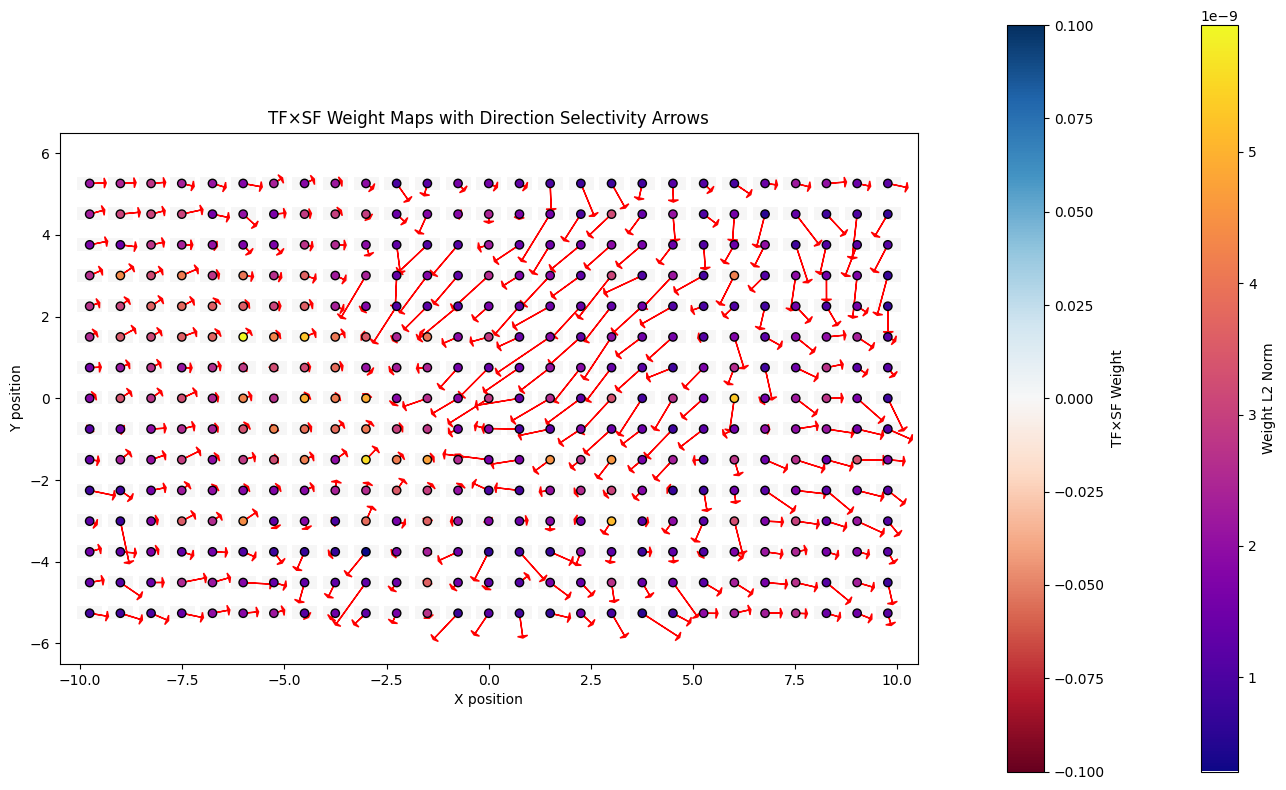

Using weight norm 0th percentile = 0.000


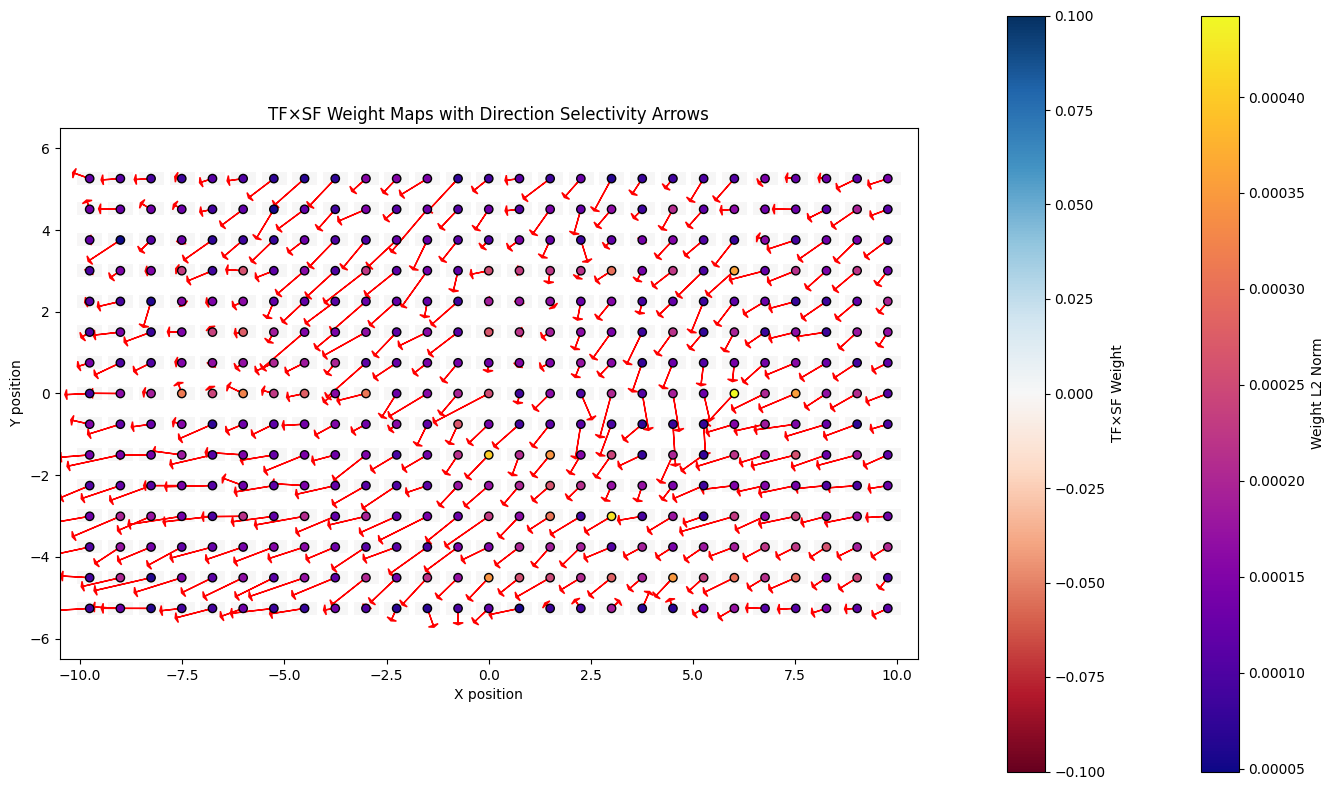

Using weight norm 0th percentile = 0.000


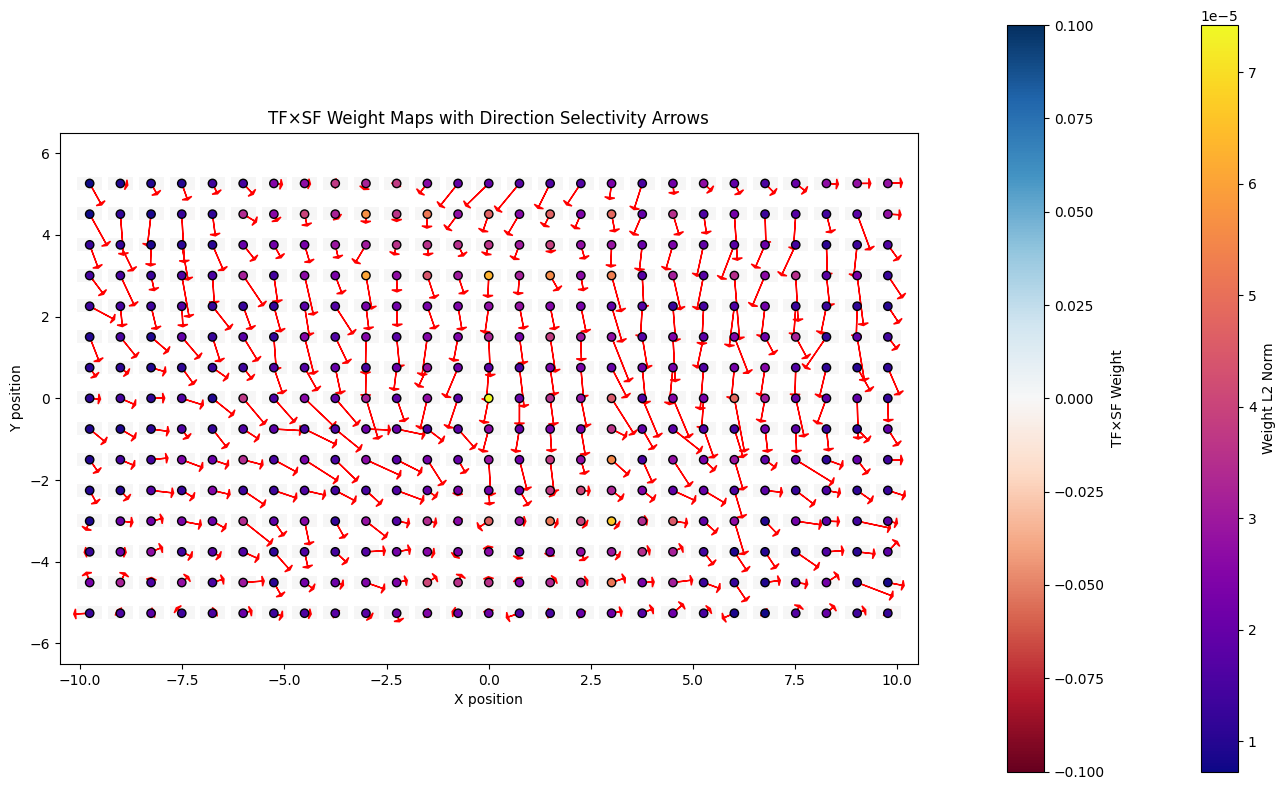

Using weight norm 0th percentile = 0.000


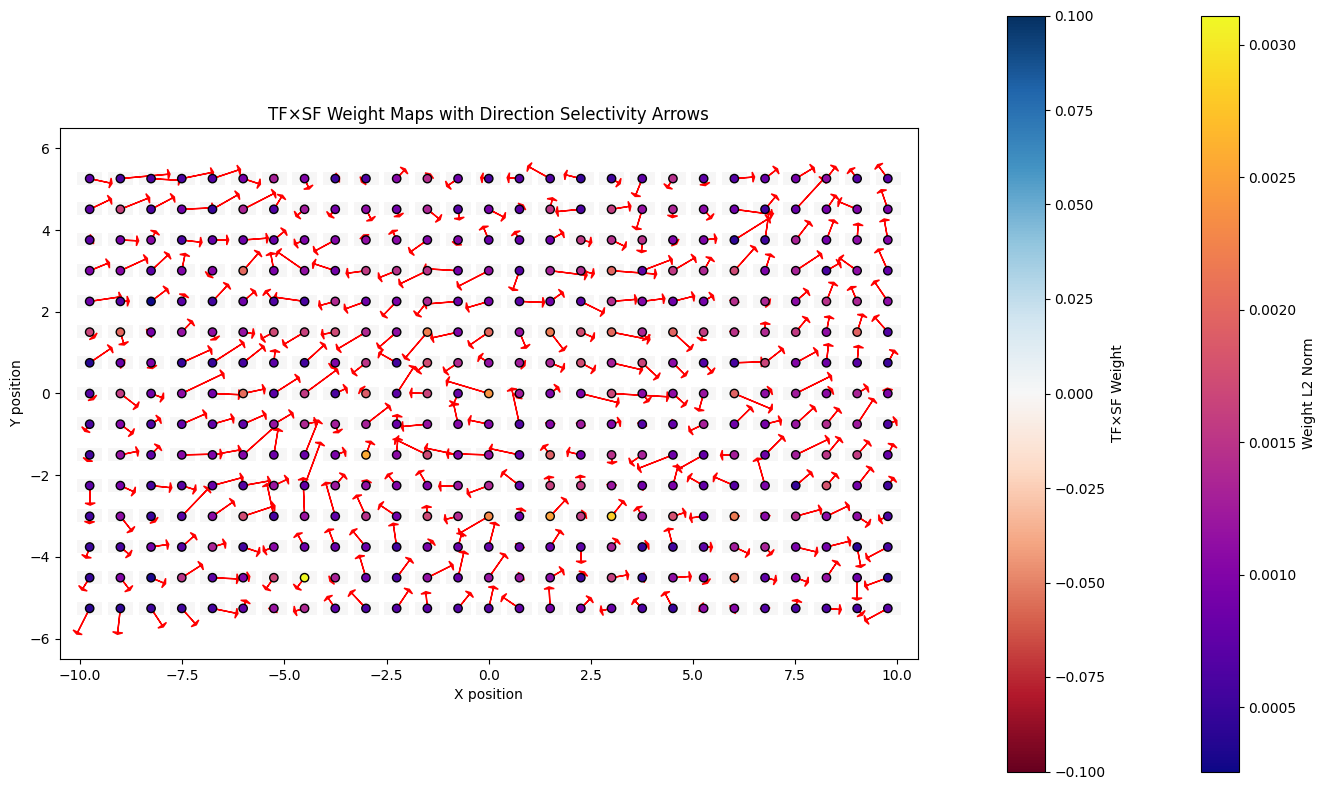

Using weight norm 0th percentile = 0.000


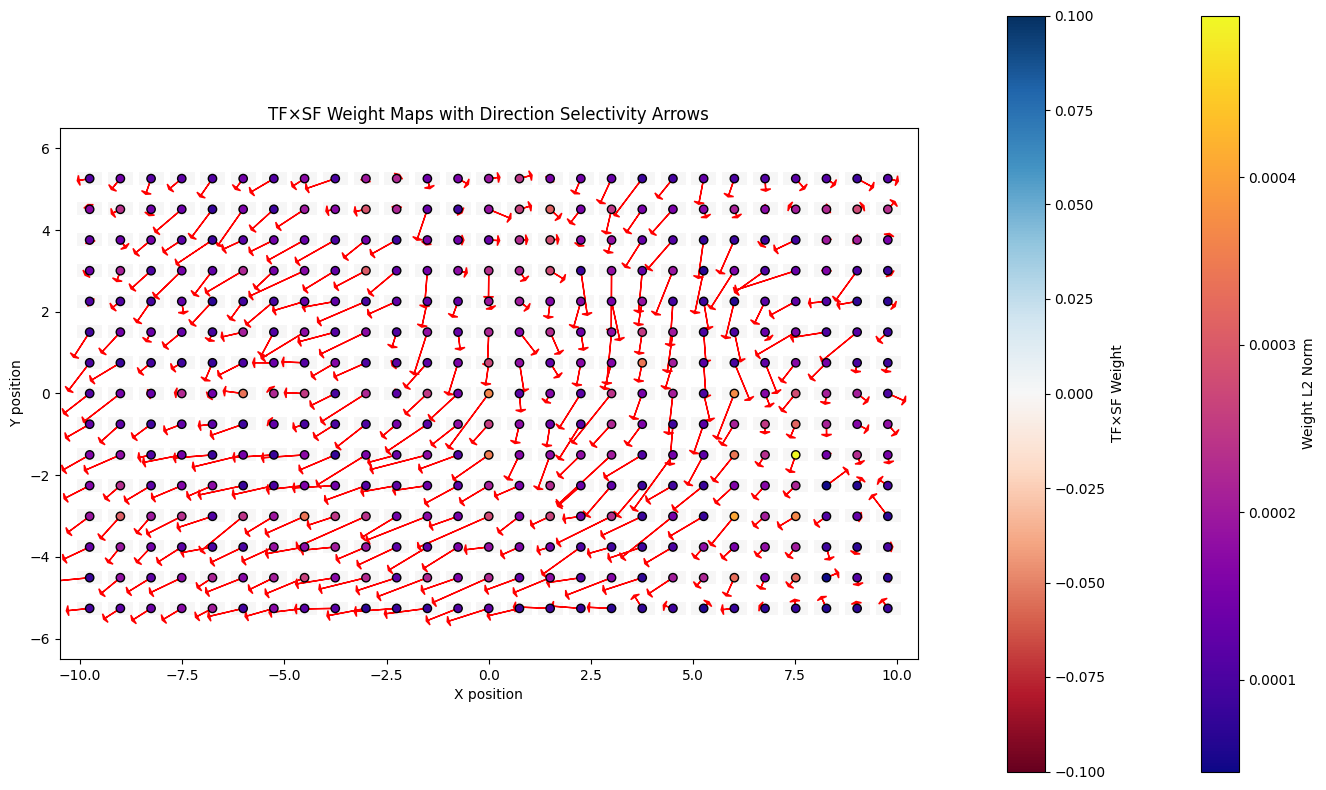

Using weight norm 0th percentile = 0.000


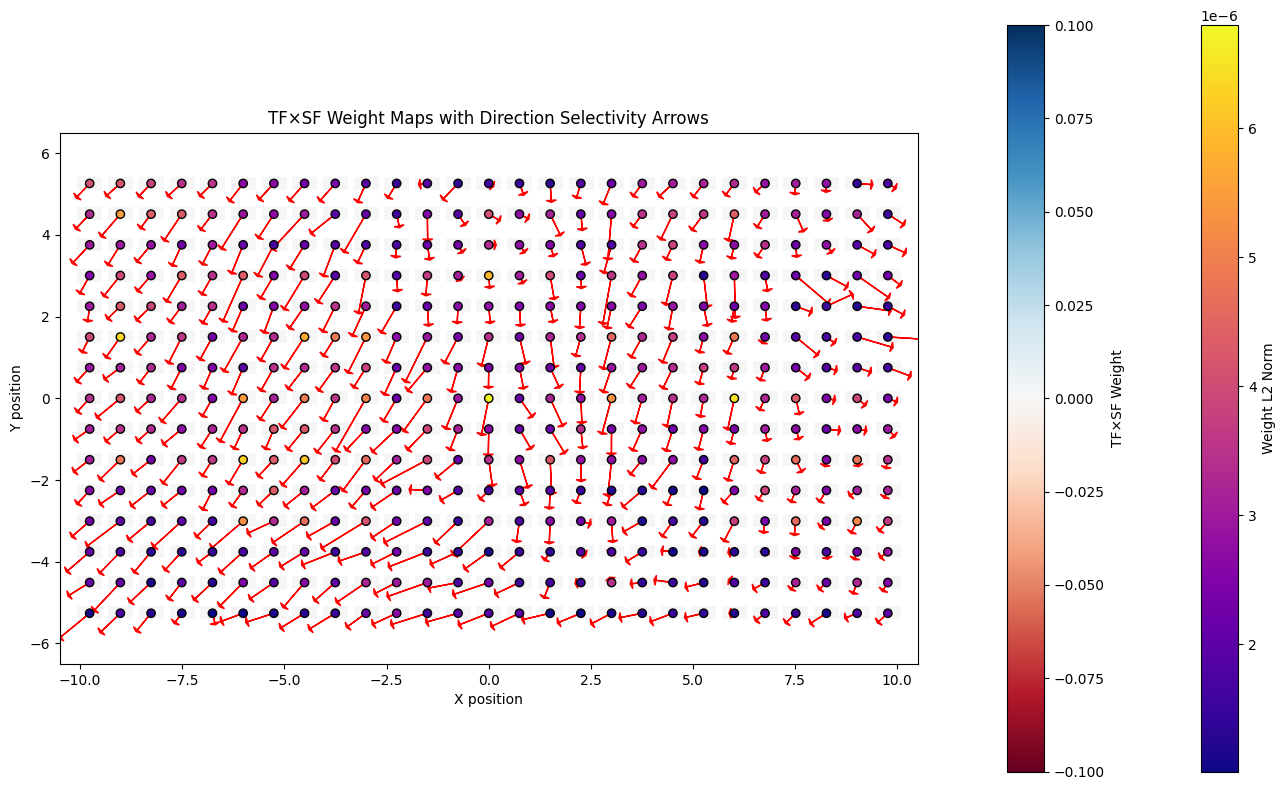

Using weight norm 0th percentile = 0.000


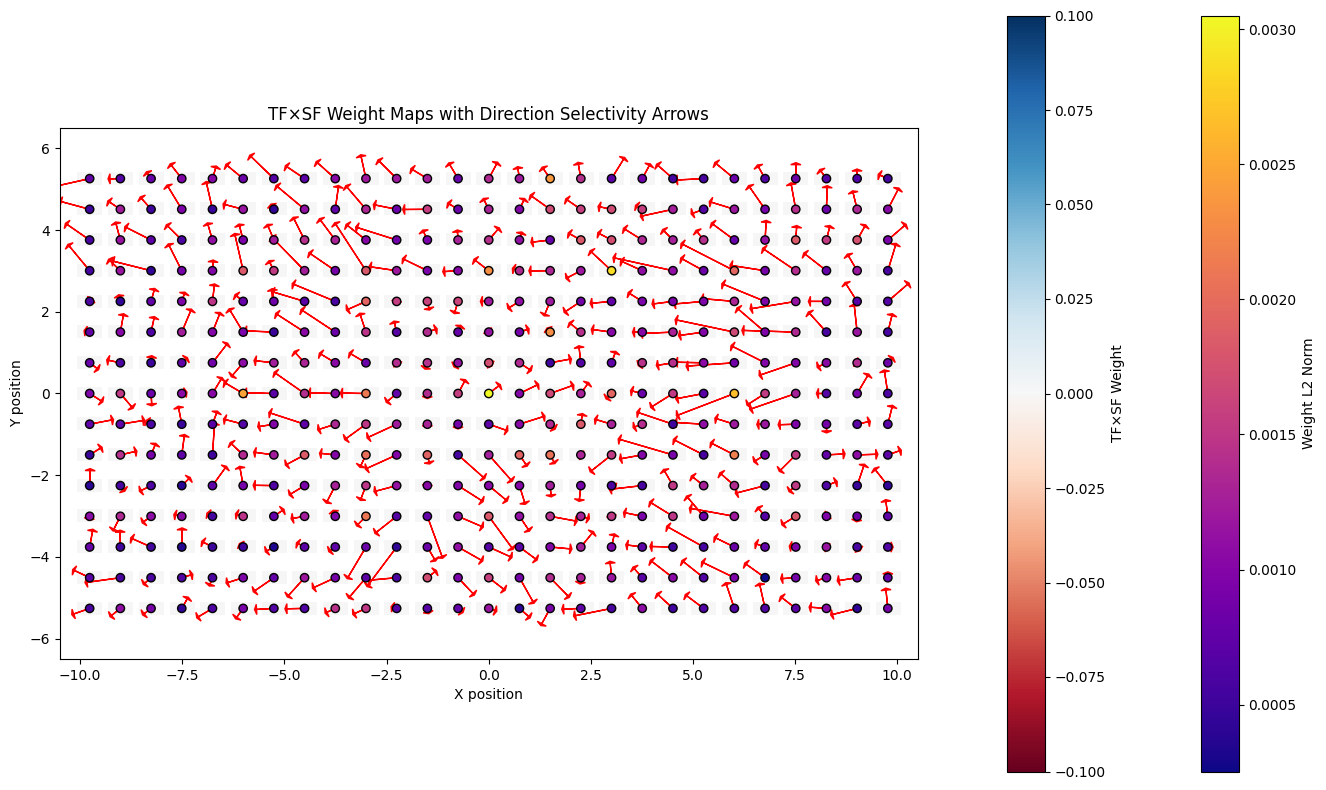

Using weight norm 0th percentile = 0.000


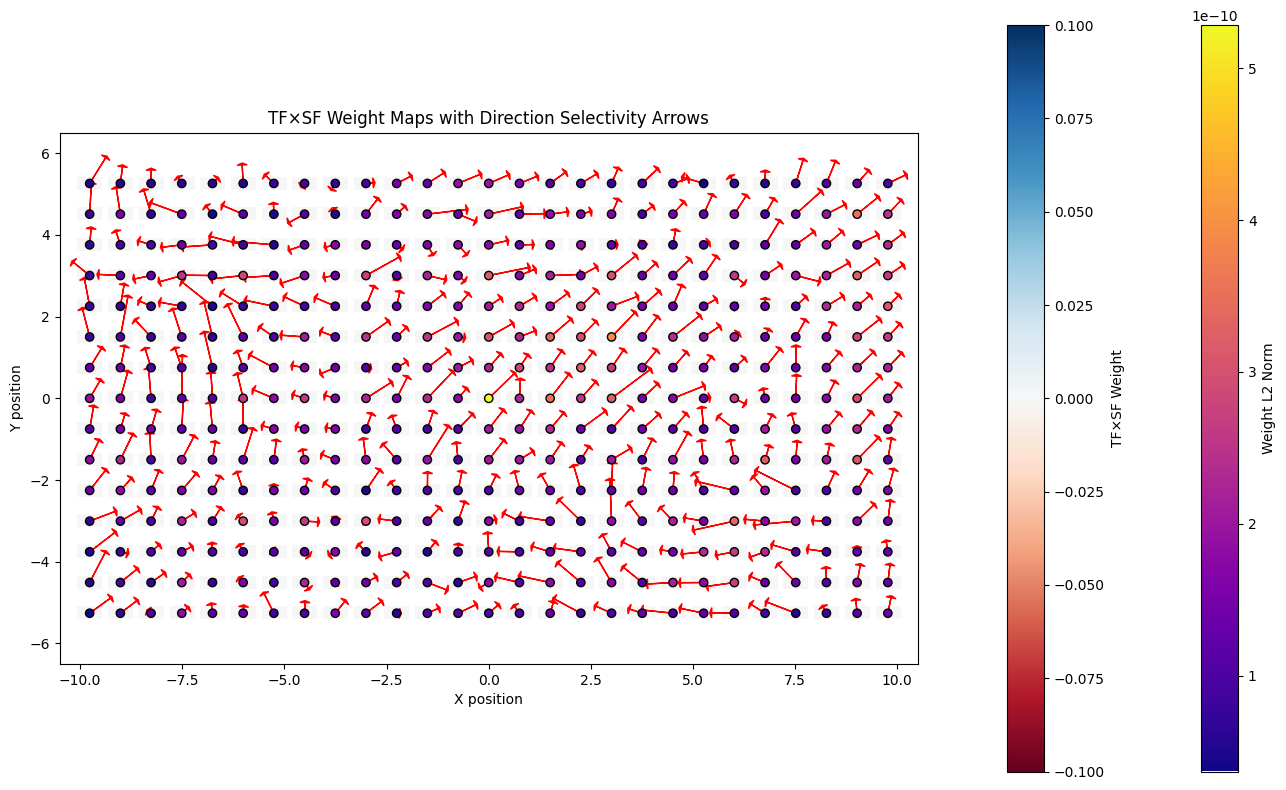

Using weight norm 0th percentile = 0.000


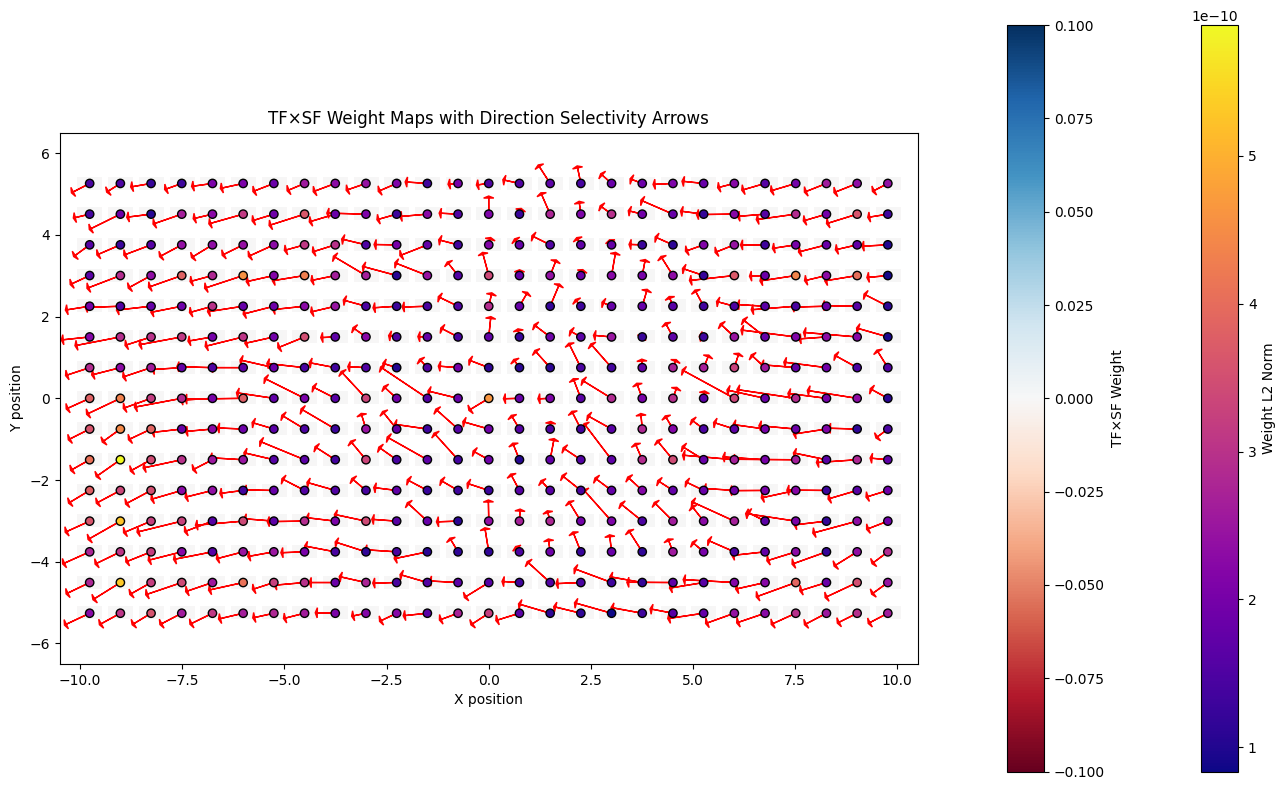

Using weight norm 0th percentile = 0.000


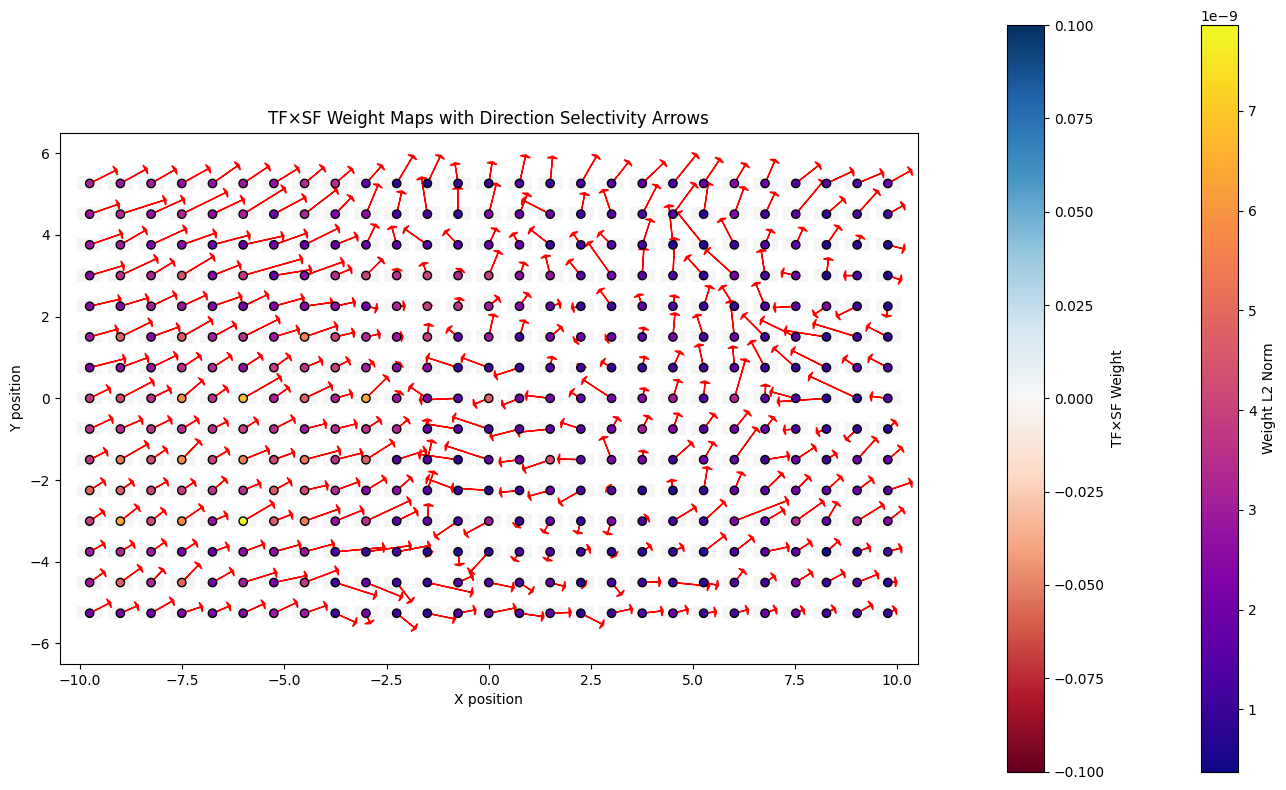

Using weight norm 0th percentile = 0.000


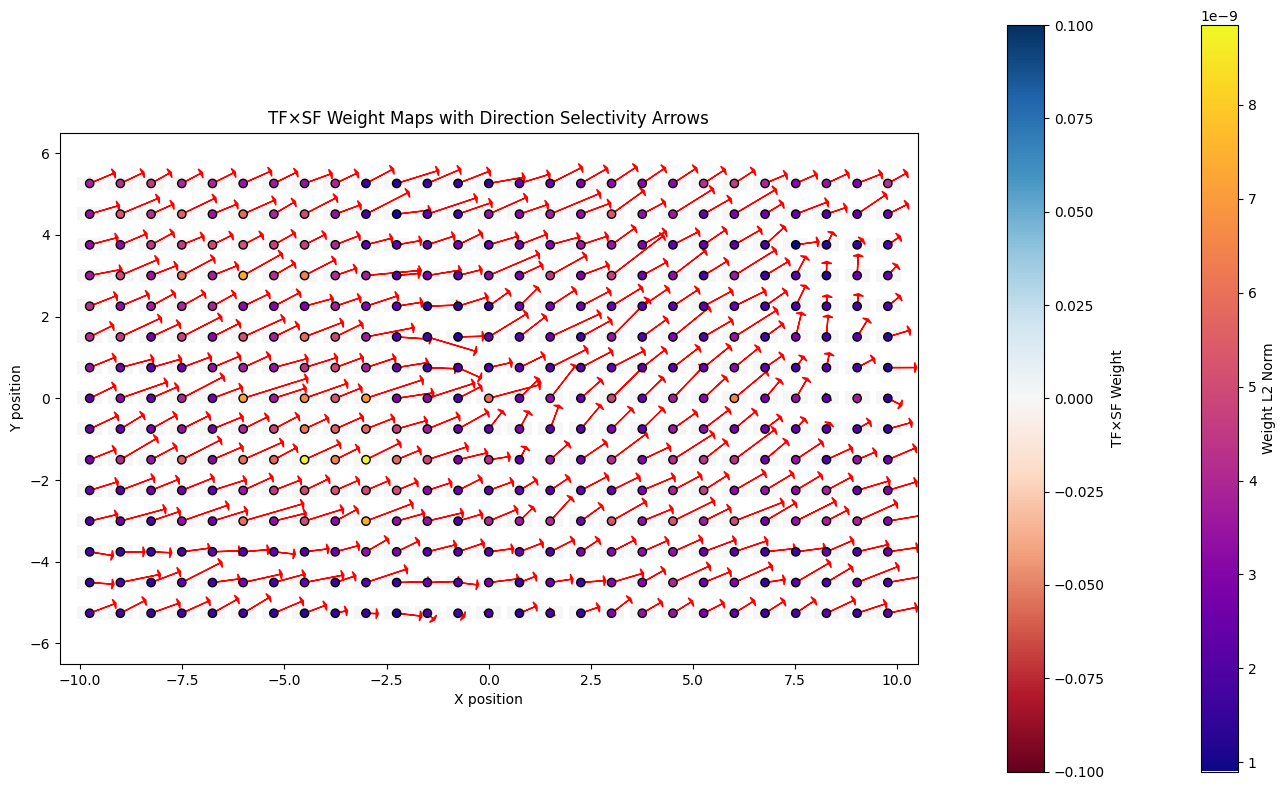

Using weight norm 0th percentile = 0.000


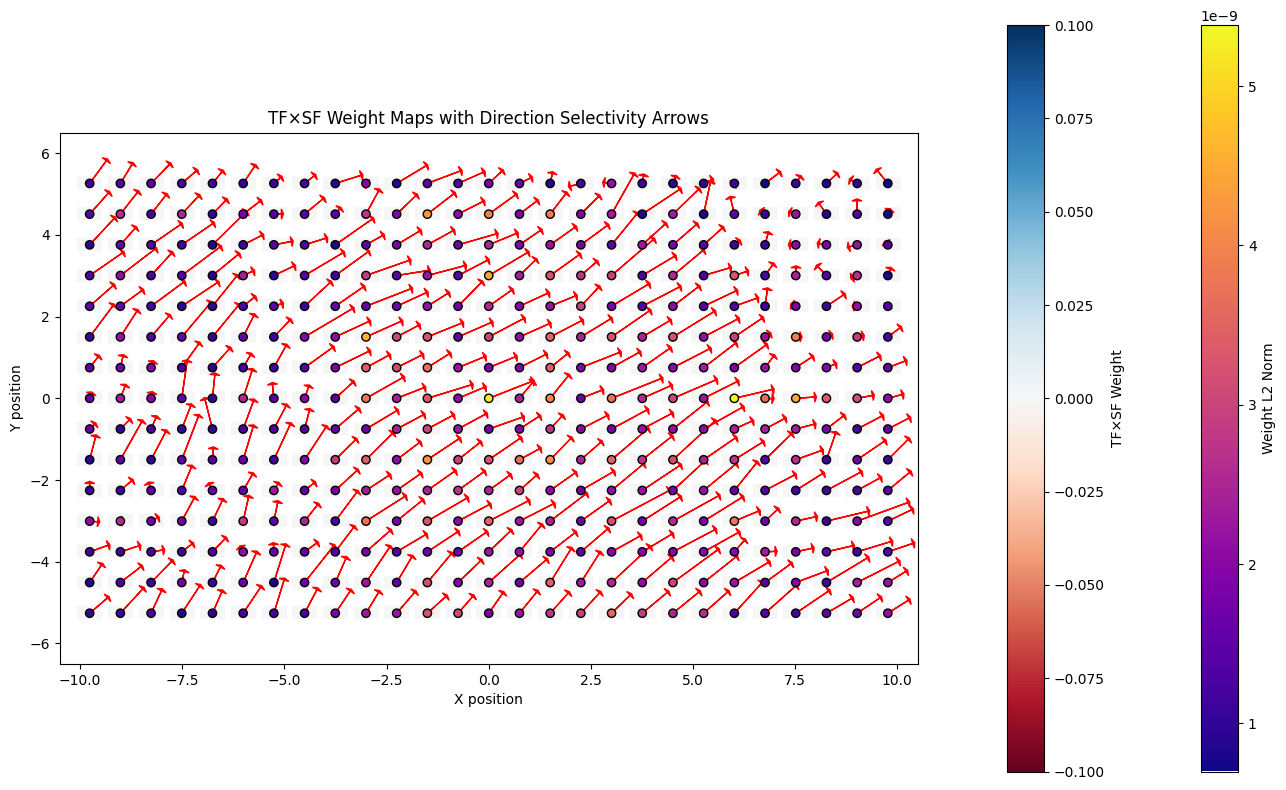

Using weight norm 0th percentile = 0.000


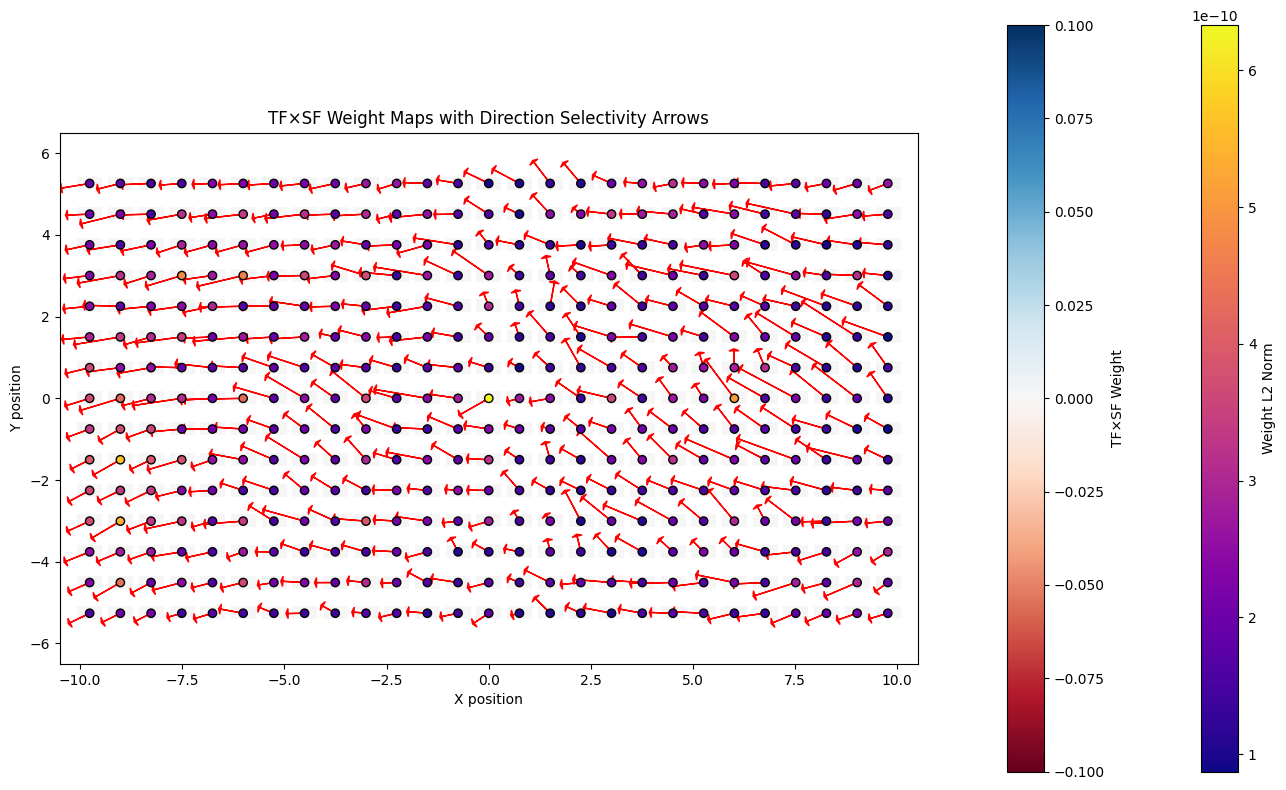

Using weight norm 0th percentile = 0.000


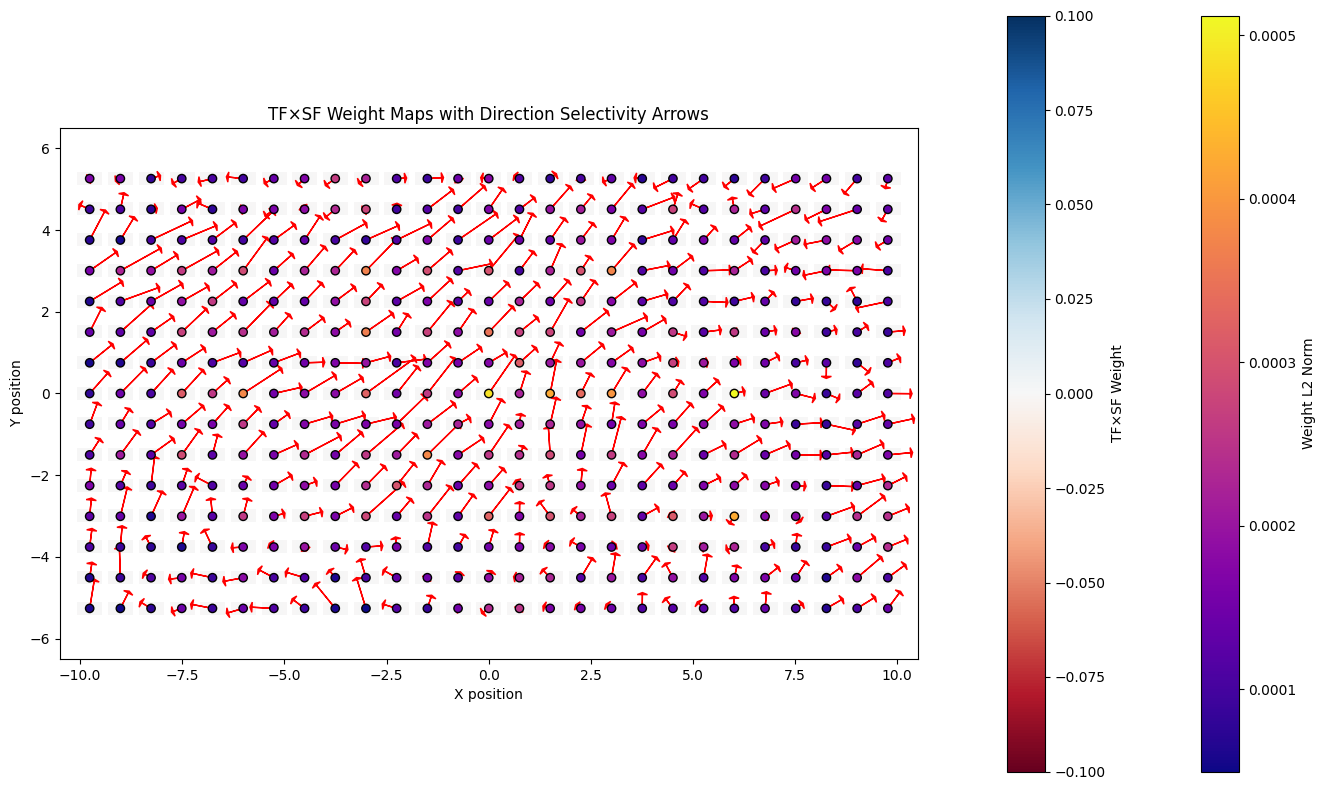

Using weight norm 0th percentile = 0.000


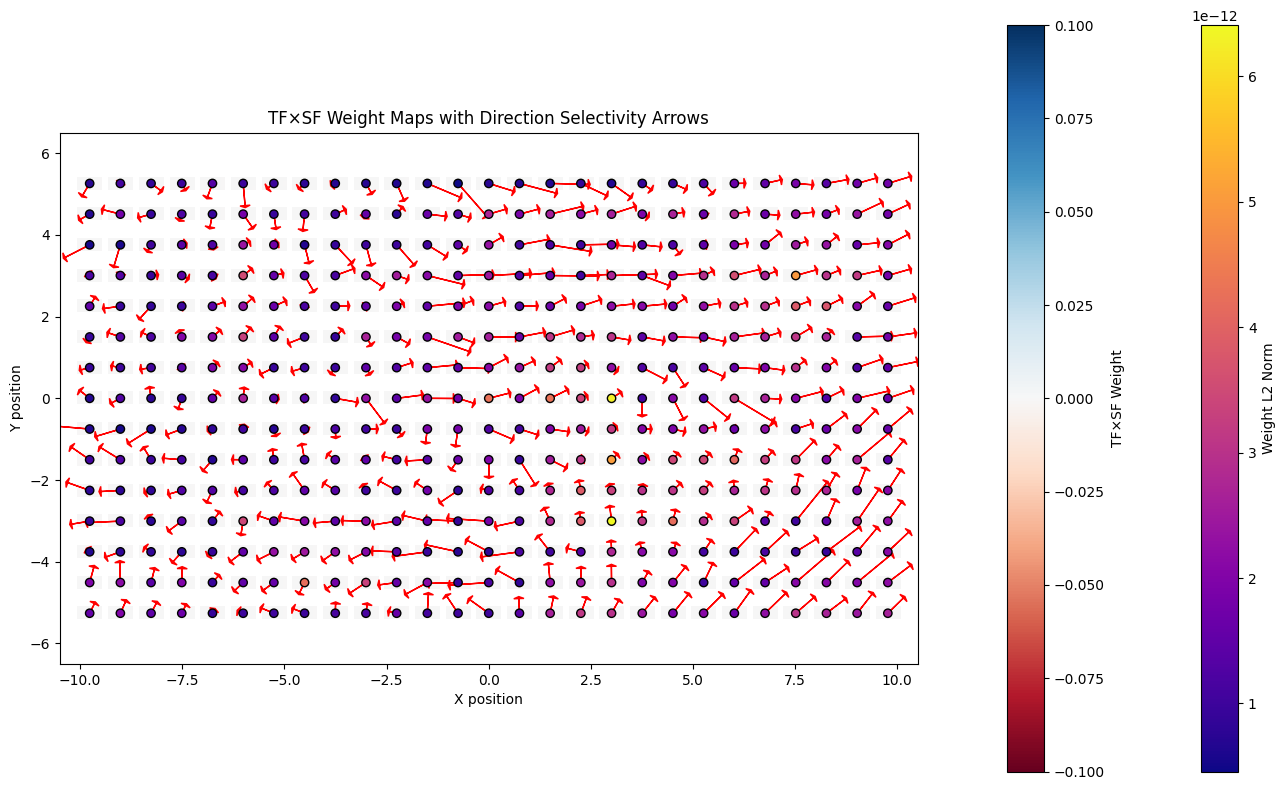

Using weight norm 0th percentile = 0.000


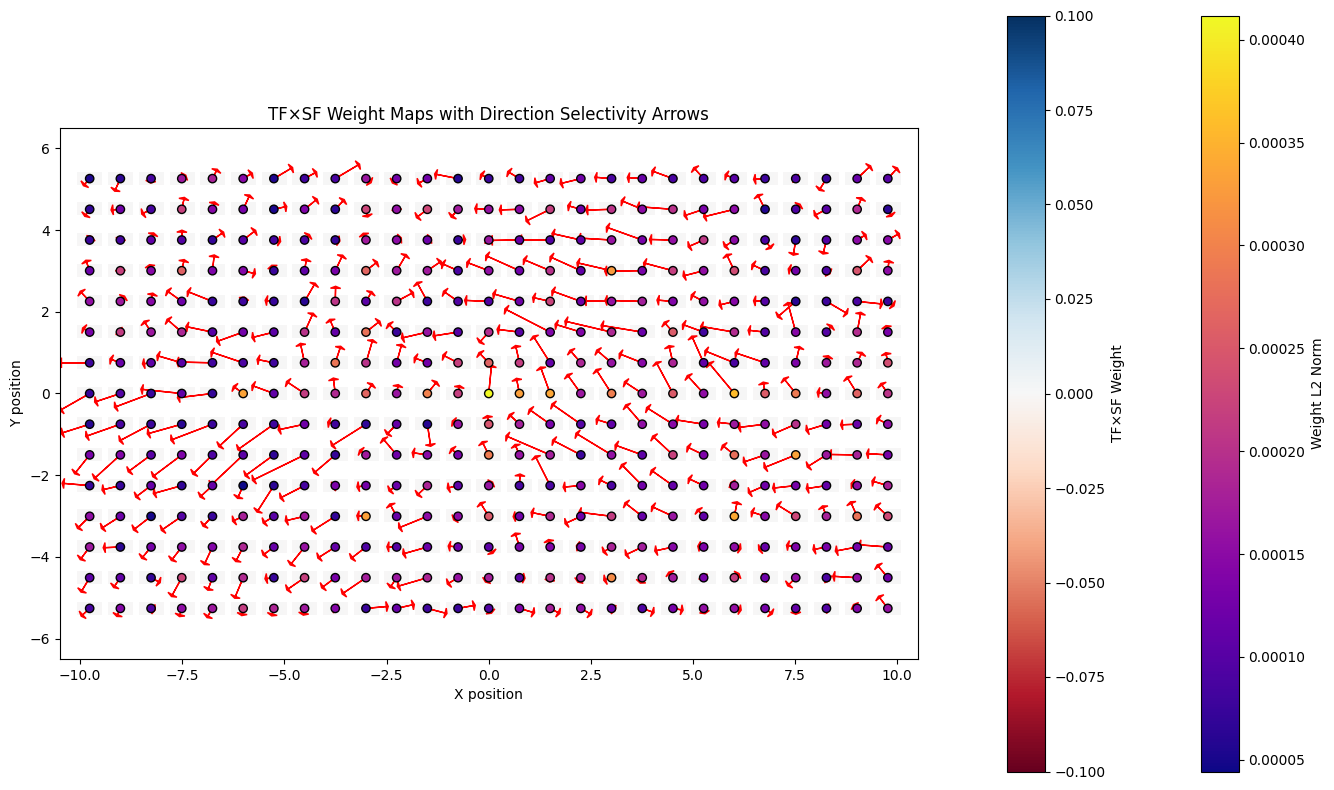

Using weight norm 0th percentile = 0.000


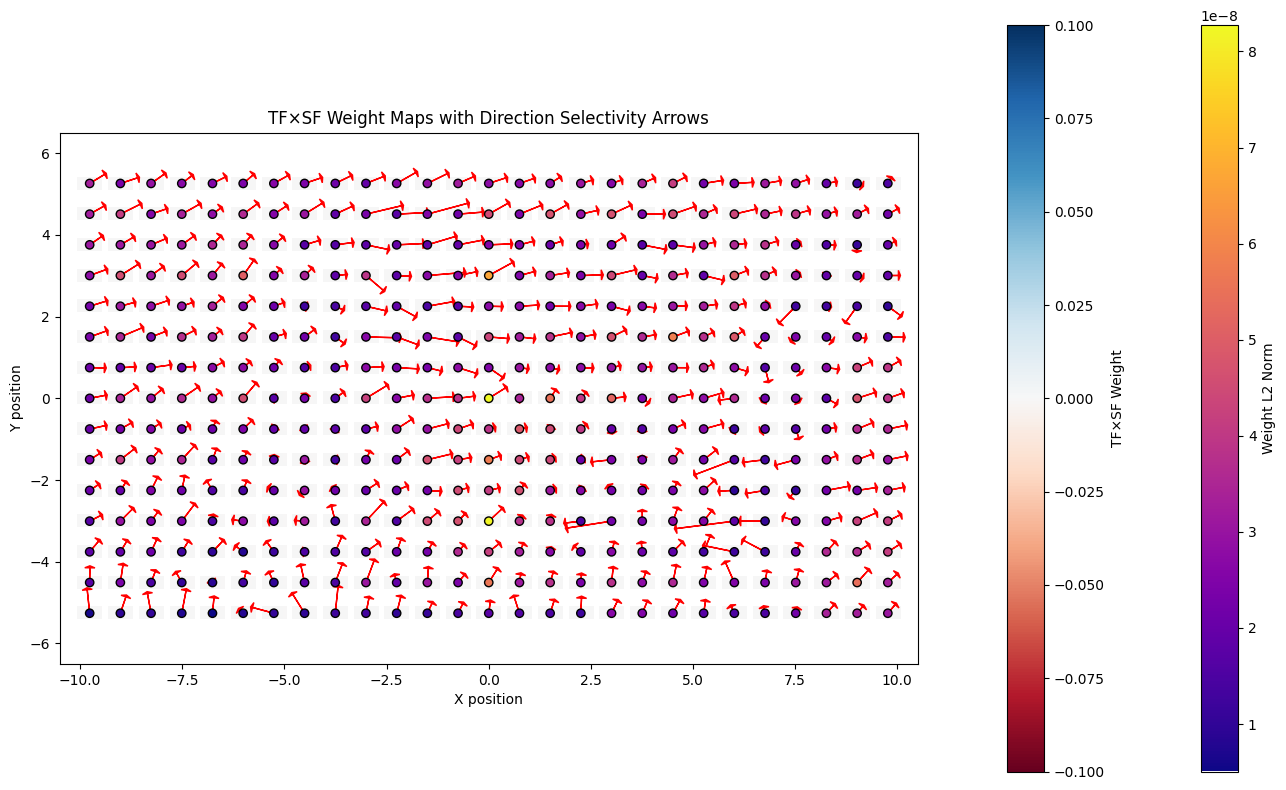

Using weight norm 0th percentile = 0.000


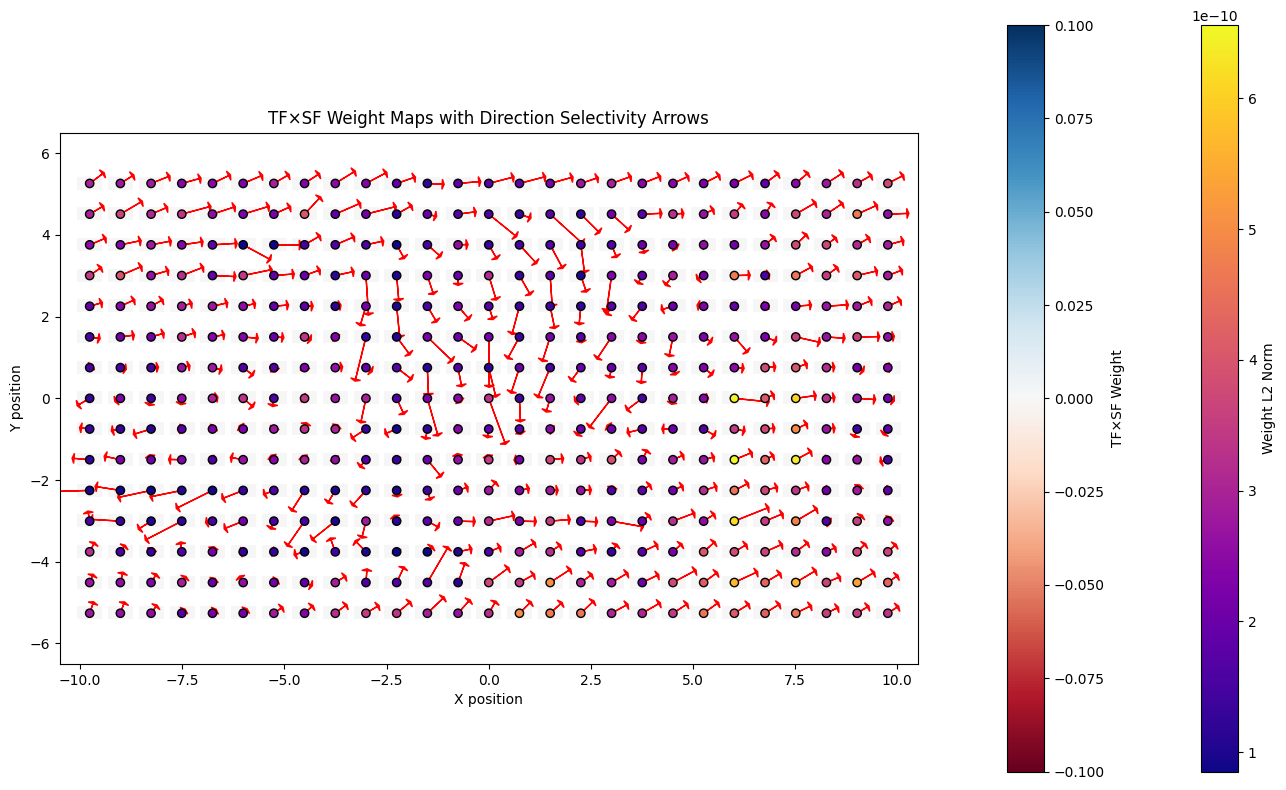

Using weight norm 0th percentile = 0.000


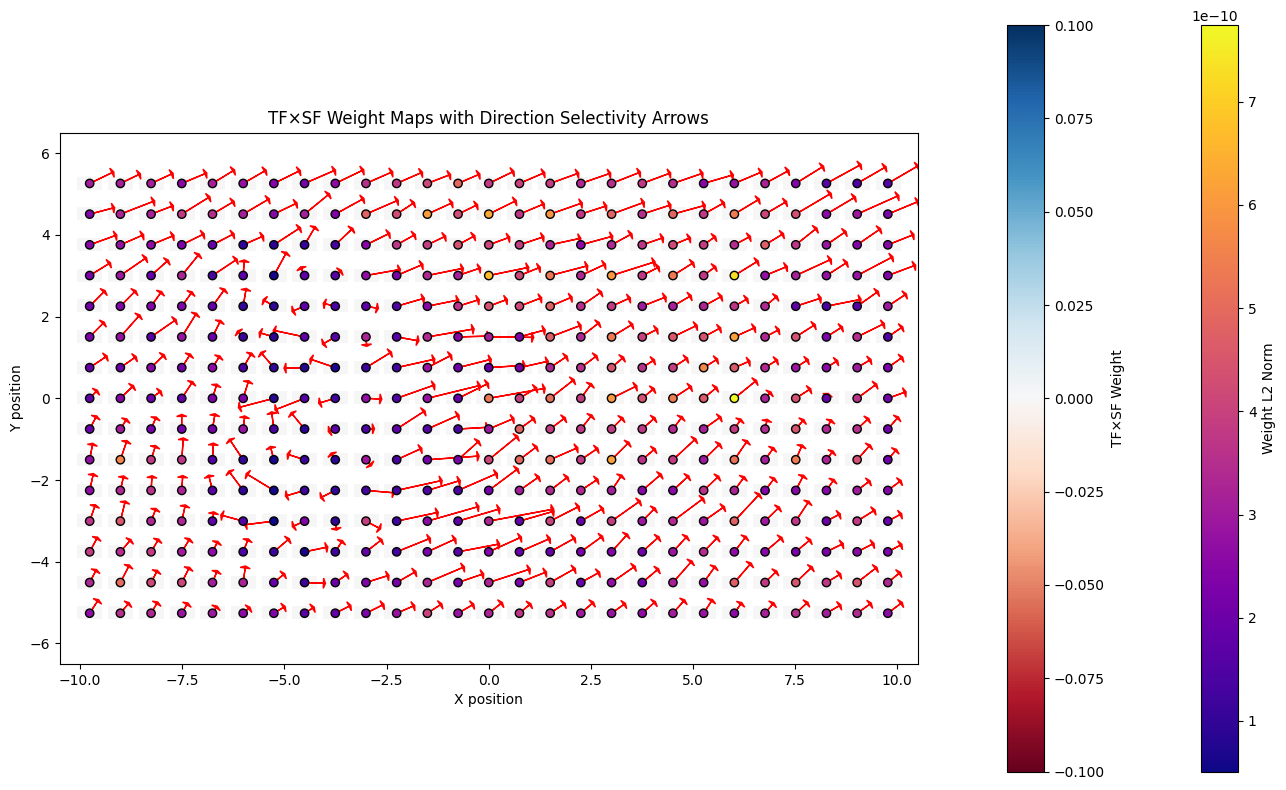

Using weight norm 0th percentile = 0.000


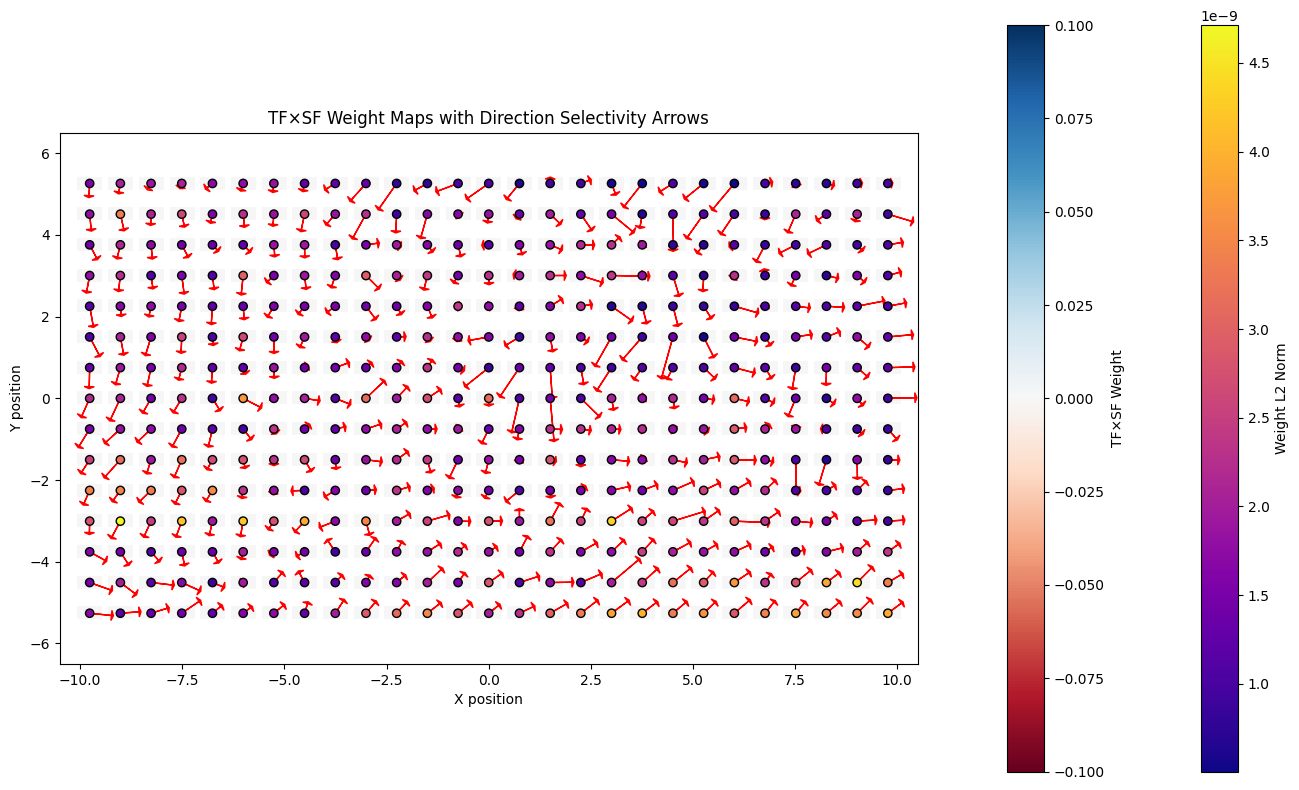

In [11]:
idx_good = np.argsort(r2_flat)[::-1][:20]
for i in idx_good:
    plot_tf_sf_maps_with_dir_selectivity(
        f3, weights=primal_coef[:,i], 
        vmin=-1e-1, vmax=1e-1, 
        cmap='RdBu', 
        percentile_threshold=0
        )

Using weight norm 0th percentile = 0.000


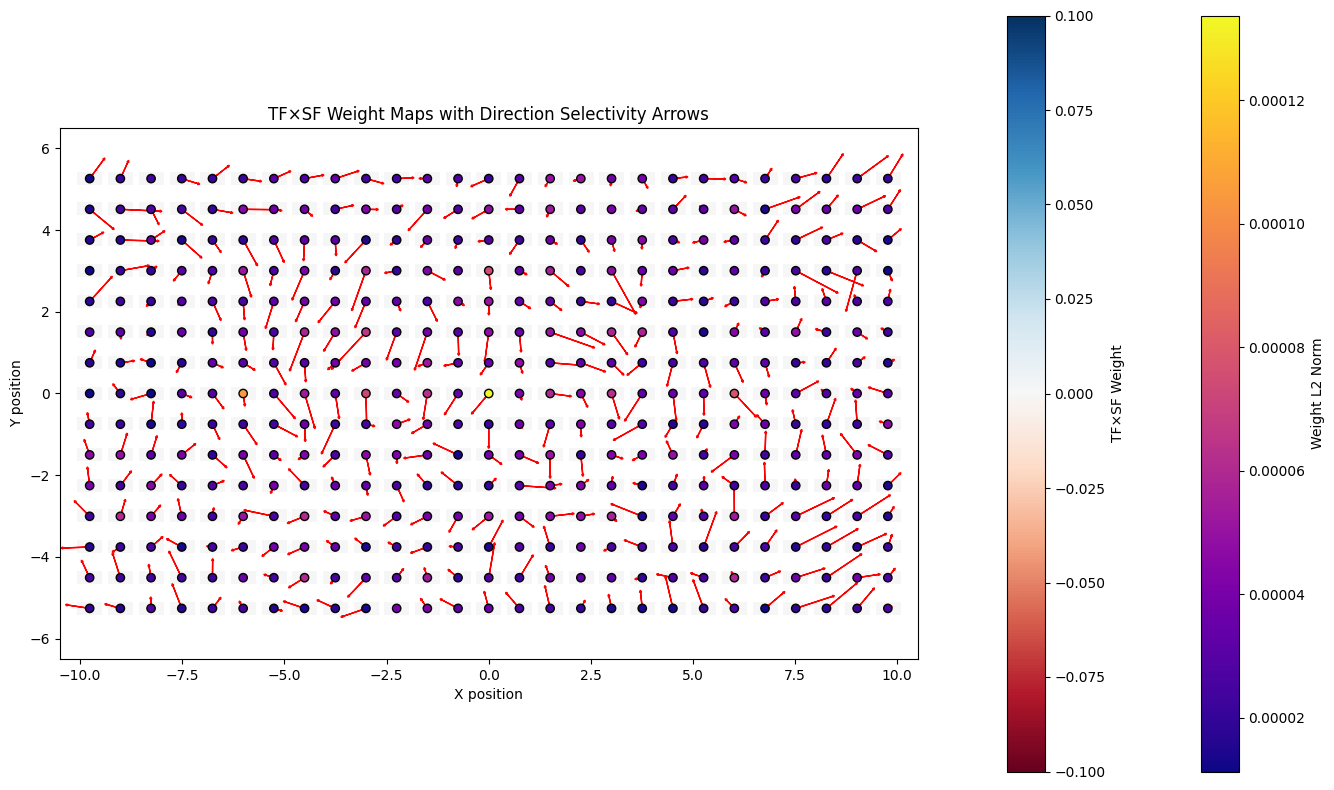

In [239]:
plot_tf_sf_maps_with_dir_selectivity(
    f3, weights=primal_coef.mean(axis=-1), 
    vmin=-1e-1, vmax=1e-1, 
    cmap='RdBu', 
    percentile_threshold=0
    )

In [23]:
primal_coef[:,9021]

array([ 1.0109906e-10,  2.7904229e-10, -5.5947302e-10, ...,
       -1.4629419e-10, -1.1709413e-10, -1.4238838e-10],
      shape=(11845,), dtype=float32)

Overall weight 0th percentile:-0.010


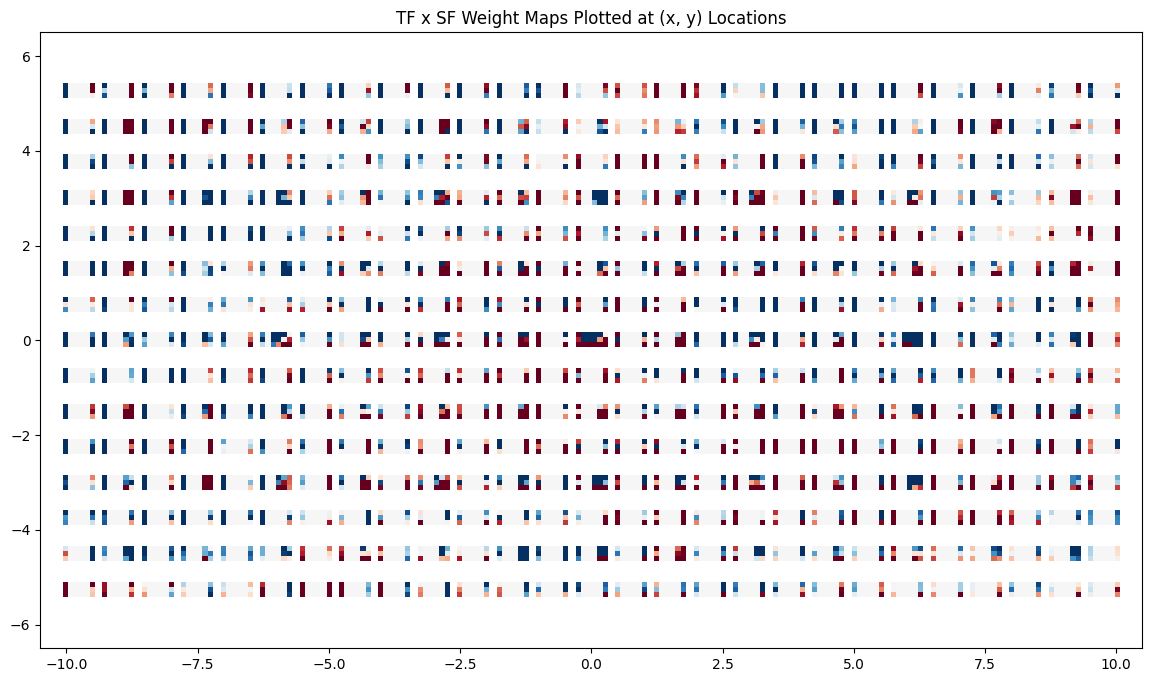

Overall weight 0th percentile:-0.015


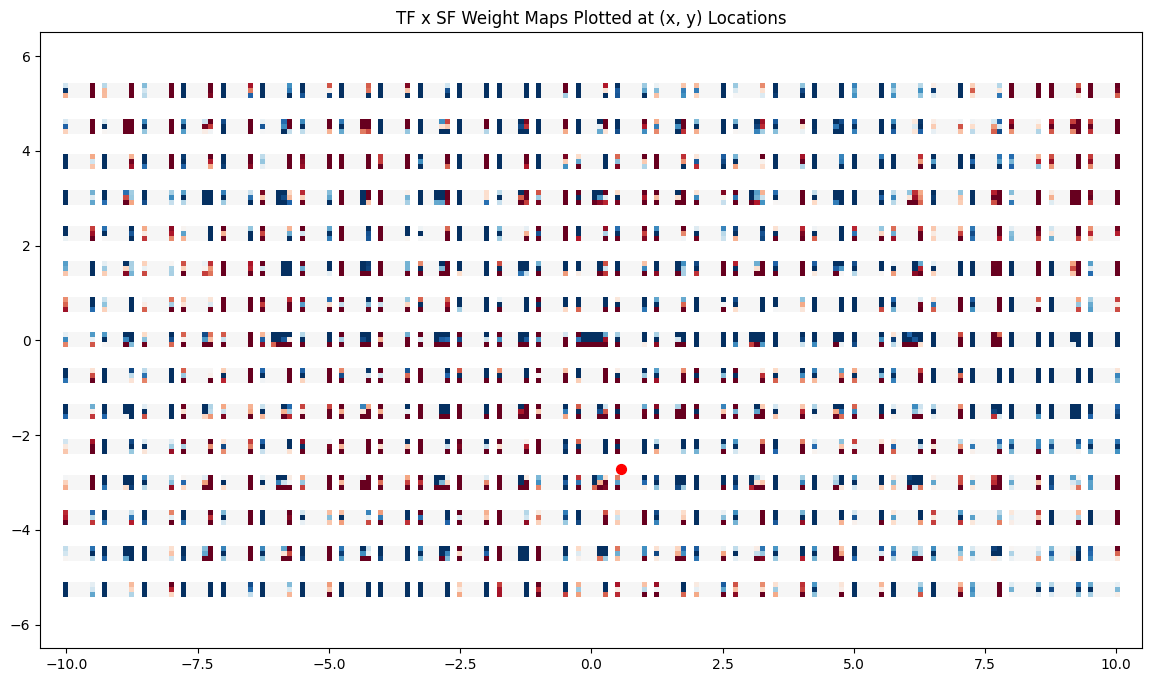

In [231]:
for i in range(1000,1002):
    plot_tf_sf_maps(f3, weights=primal_coef[:,i], wxy=(wm['x'][i], wm['y'][i]), vmin=-0.0001, vmax=0.0001, cmap='RdBu', pc=0)
    

In [229]:
(wm['x'][i], wm['y'][i])

(np.float64(0.5679299544209623), np.float64(-2.71852094433324))

In [15]:
primal_coef.shape

(11845, 352914)

In [102]:
# wm = f3.filter_weighted_mean(primal_coef, ) #params=['pol'])
dir_s = f3.p_selectivity(
    primal_coef, param='x'
)

In [120]:
import numpy as np
from sklearn.decomposition import PCA

# Suppose data is a numpy array of shape (n_instances, n_features)
# If yours is (n_features, n_instances), just transpose it:
# data = data.T

# Initialize PCA: choose number of components (e.g. 2) or fraction of variance
pca = PCA(n_components=2)    
# Fit & transform the data
X_reduced = pca.fit_transform(primal_coef.T)  # Transpose to shape (n_instances, n_features)

print("Explained variance ratios:", pca.explained_variance_ratio_)
print("Projected shape:", X_reduced.shape)

Explained variance ratios: [0.17036949 0.14859624]
Projected shape: (352914, 2)


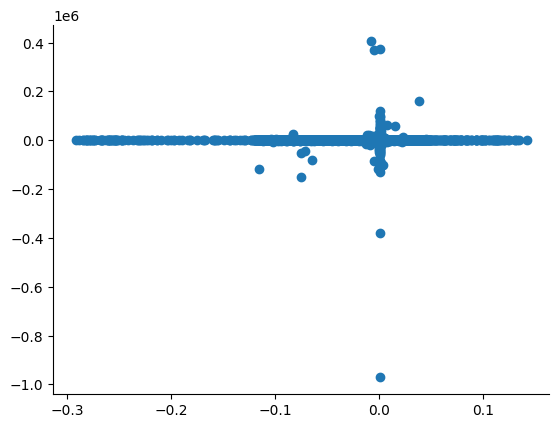

In [ ]:
from dpu_mini.plot_functions import *
dag_scatter(
    X_reduced[:, 1], 
    wm['x'],
    
)

In [135]:
np.max(wm['x'])

np.float64(404406.45309468656)

In [134]:
wm = f3.filter_weighted_mean(primal_coef,)

(array([7.2000e+01, 5.5100e+02, 1.6880e+03, 3.4960e+03, 6.2310e+03,
        1.0082e+04, 1.7588e+04, 2.7966e+04, 3.7580e+04, 4.3231e+04,
        4.2912e+04, 3.8931e+04, 3.2553e+04, 2.5400e+04, 1.9227e+04,
        1.3894e+04, 9.5730e+03, 6.8980e+03, 4.6830e+03, 3.2370e+03,
        2.2450e+03, 1.5390e+03, 1.0530e+03, 7.0800e+02, 4.7100e+02,
        3.1300e+02, 2.1400e+02, 1.8200e+02, 1.0400e+02, 1.0400e+02,
        5.4000e+01, 4.4000e+01, 2.4000e+01, 2.5000e+01, 1.1000e+01,
        5.0000e+00, 7.0000e+00, 5.0000e+00, 5.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.02557739, 0.03233297, 0.03908855, 0.04584414, 0.05259972,
        0.0593553 , 0.06611089, 0.07286647, 0.07962205, 0.08637764,
        0.09313321, 0.09988879, 0.10664438, 0.11339996, 0.12015554,
        0.12691113, 0.13366671, 0.1404223 , 0.14717788, 0.15393347,
        0.16068904, 0.16744463, 0.17420021, 0.

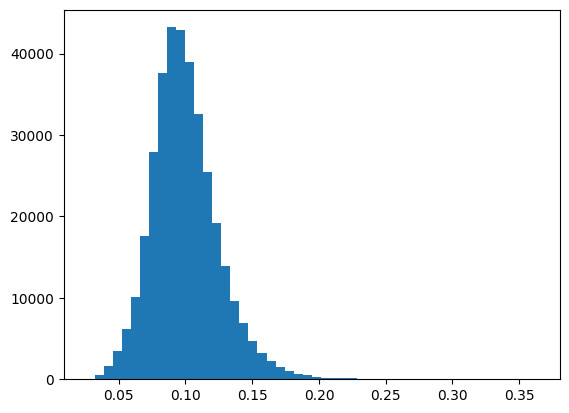

In [103]:
plt.hist(dir_s, bins=50)

In [106]:
np.where(dir_s>0.3)

(array([120238, 209397, 272846, 278236, 278327]),)

In [109]:
dir_sel = f3.p_selectivity(
    primal_coef, param='dir'
)

In [116]:
np.where(dir_sel>0.7)

(array([   671,   1503,   1539,   2006,   2579,   2582,   2987,   4166,
          6638,   7013,   7529,   9141,   9299,   9580,   9947,  10163,
         10428,  11654,  13850,  16498,  17569,  23310,  23962,  24919,
         25219,  26393,  28712,  28816,  29168,  30055,  31493,  33135,
         33184,  34279,  35172,  35400,  36658,  38430,  38991,  43471,
         43619,  45524,  46078,  46552,  46679,  47238,  47536,  50284,
         50570,  53065,  55559,  56004,  56182,  56616,  57864,  58873,
         59139,  60312,  60599,  60699,  62393,  63096,  64319,  64360,
         65010,  65282,  65497,  65624,  65773,  65882,  66451,  66606,
         68014,  68815,  69626,  70927,  72589,  72956,  73560,  73765,
         74278,  74495,  75539,  76115,  78320,  78701,  78800,  79539,
         80161,  80405,  81981,  82483,  83878,  84171,  85126,  86523,
         86742,  87188,  89482,  89638,  89924,  89999,  90510,  91157,
         91395,  91637,  92454,  92800,  92859,  92922,  93995, 

(array([1.28810e+04, 7.36700e+04, 1.26362e+05, 7.85760e+04, 3.61170e+04,
        1.63860e+04, 6.59900e+03, 1.92600e+03, 3.71000e+02, 2.60000e+01]),
 array([0.01936523, 0.10655743, 0.19374964, 0.28094181, 0.36813402,
        0.45532623, 0.54251844, 0.62971067, 0.71690285, 0.80409503,
        0.89128727]),
 <BarContainer object of 10 artists>)

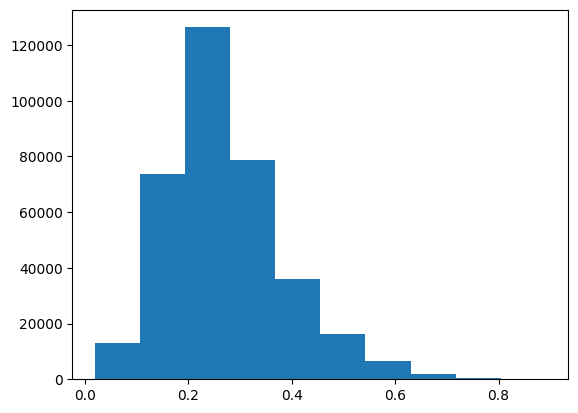

In [110]:
plt.hist(dir_sel, )

In [ ]:
dag_scatter(
    f3.pyramid.parameters['spatial_env'],
    f3.pyramid.parameters['spatial_freq'],
)

# plt.show()

In [ ]:
((f3.pyramid.parameters['spatial_env']==0.3) & (f3.pyramid.parameters['spatial_freq']==8.0)).sum()

In [ ]:
np.unique(f3.pyramid.parameters['spatial_freq'])
np.unique(f3.pyramid.parameters['spatial_env'])

In [40]:
# with open('wm.pkl', 'wb') as f:
#     pickle.dump(wm, f)
with open('wm.pkl', 'rb') as f:
    wm = pickle.load(f)

In [41]:
wm

x          y        ecc       pol          SF      size  \
0        3.239301   6.376469   7.790396  1.100762  330.029703  0.283647   
1       -0.618531  -2.049872   8.281636 -1.863850  300.517509  0.291680   
2       52.230245  -6.748716  18.076176 -0.128499  380.123842 -0.121982   
3      -59.860482  52.976121  69.731574  2.417131  267.455861 -0.100555   
4        0.340997  10.583196  18.100870  1.538587  184.736442  0.273093   
...           ...        ...        ...       ...         ...       ...   
352909   7.771524  18.560300  10.692578  1.174259  315.134023  0.295812   
352910   0.901114   2.188089  15.521511  1.180136  319.939756  0.269297   
352911  29.159969  -2.480832  14.683865 -0.084872  348.201013  0.156159   
352912   1.680794   1.195631   9.978224  0.618302  291.222874  0.285857   
352913   2.886117   0.003095  10.784141  0.001072  274.886100  0.254127   

              TF         dir       vel  
0       2.346221   92.652904  0.007903  
1       2.226720   29.083379  0.007893  
2       0.987638   40.789216 -0.011655  
3       3.663207  272.228142  0.000106  
4       1.595361  213.553032  0.000117  
...          ...         ...       ...  
352909  3.321835  346.097982  0.011038  
352910  2.362066  257.143296  0.008194  
352911  5.217506  155.788573  0.015173  
352912  2.078635   83.985315  0.007152  
352913  2.396039    3.337925  0.006117  

[352914 rows x 9 columns]

volume shape: (84, 95, 106)
Caching mapper...
Caching mapper...


/tank/marcus/miniconda3/envs/aot_003/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


Unable to init server: Could not connect: Connection refused
Background RRGGBBAA: ffffff00
Area 0:0:1975.19:1024 exported to 1975 x 1024 pixels (96 dpi)
Unable to init server: Could not connect: Connection refused
Background RRGGBBAA: ffffff00
Area 0:0:1975.19:1024 exported to 1975 x 1024 pixels (96 dpi)


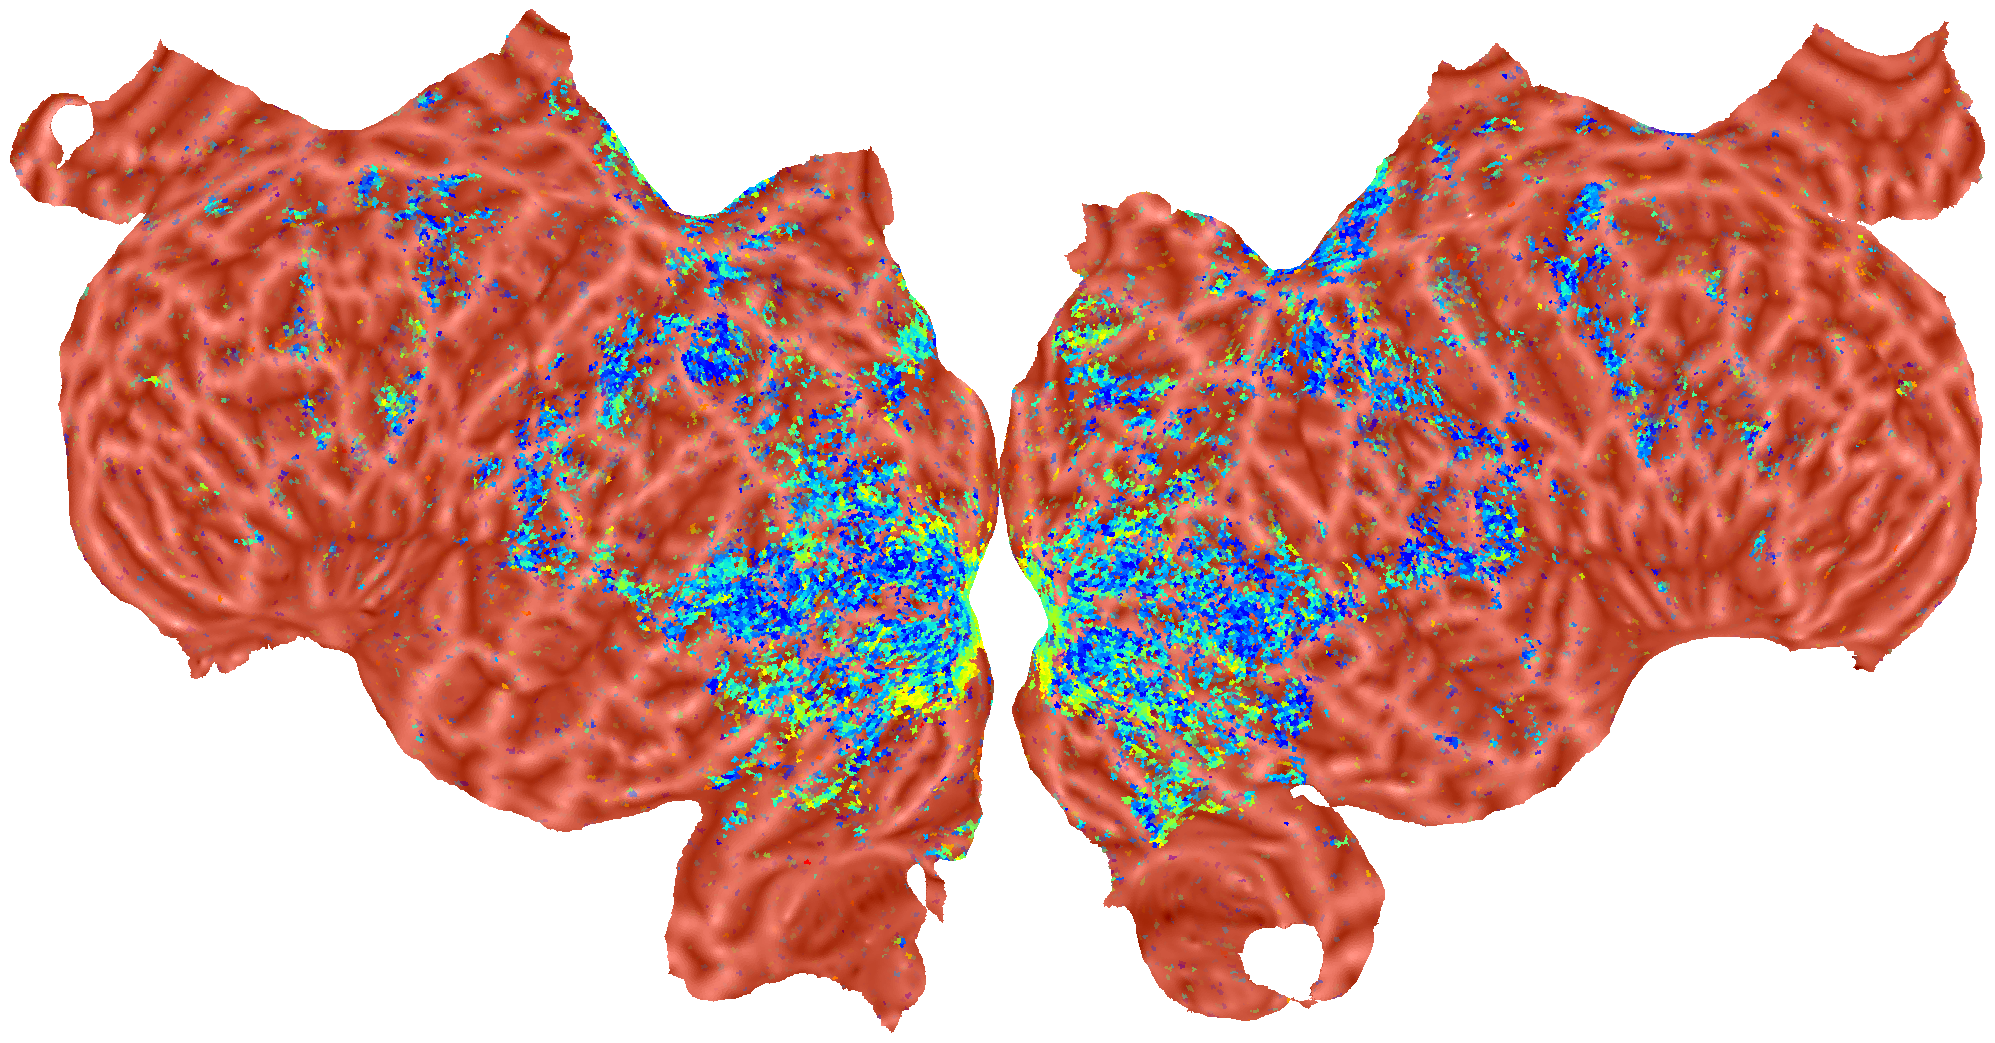

In [ ]:
# Reshape the eccentricities into a volume
p = 'pol'
vol = reshape_from_flatten_masked_to_wholebrain(
    dir_s, #
    # wm[p].to_numpy(), 
    sub=sub)
cx_sub = f'sub-{sub:03d}'
print("volume shape:", vol.shape)

# Transpose the volume to match the expected shape (106, 95, 84)
vol = np.transpose(vol, (2, 1, 0))
cx_vol = cortex.Volume(vol, cx_sub, xfmname='AOT1pt7mm',vmin=0.1, vmax=20, cmap="magma")

mapper = cortex.get_mapper(cx_sub, "AOT1pt7mm", type="nearest", recache=True)
p_map = mapper(cx_vol)

volume_R2 = cortex.Volume(R2_data, cx_sub, "AOT1pt7mm", recache=True)
mapper_R2 = cortex.get_mapper(cx_sub, "AOT1pt7mm", type="nearest", recache=True)
R2_map = mapper_R2(volume_R2)
cmap_kwargs = {
    "cmap": "jet",
    "vmin": 0,
    "vmax": 0.8,
}
# Create merged map with R2 as opacity
merged_map = Vertex2D_fix(
    p_map.data,
    R2_map.data,
    cx_sub,

    vmin2=0,
    vmax2=0.01,  # R2 threshold for opacity
    **cmap_kwargs
)
# from dag_prf_utils.plot_functions import *


# Set colormap for surface map
# p_map.cmap = "hsv"

# Display the merged map
_ = cortex.quickshow(
    merged_map,
    with_curvature=False,
    with_colorbar=False,
    with_labels=True,
    with_sulci=True,
    with_legend=False,
    # cmap="hsv",
    colorbar_label=p,
)

# Add figure (a) to plt.gcf()



from dag_prf_utils. import *
dag_plot

(array([1.28810e+04, 7.36700e+04, 1.26362e+05, 7.85760e+04, 3.61170e+04,
        1.63860e+04, 6.59900e+03, 1.92600e+03, 3.71000e+02, 2.60000e+01]),
 array([0.01936523, 0.10655743, 0.19374964, 0.28094181, 0.36813402,
        0.45532623, 0.54251844, 0.62971067, 0.71690285, 0.80409503,
        0.89128727]),
 <BarContainer object of 10 artists>)

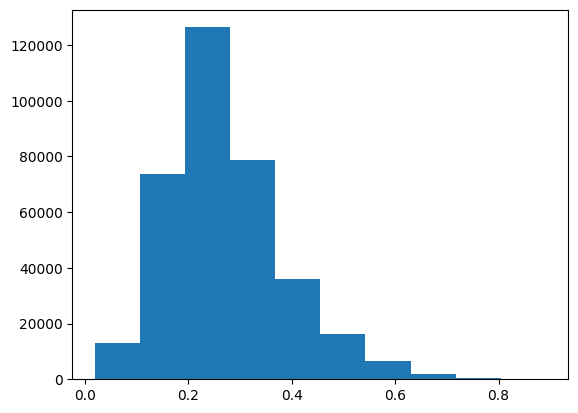

In [19]:
plt.hist(dir_s)

In [11]:
from dpu_mini.mesh_maker import GenMeshMaker

Could not find path for freeview, is freesurfer accessible from here?
Could not find FS_LICENSE
Uncomment line below and specify path to FS_LICENSE
SUBJECTS_DIR not found in os.environ
Adding empty string...


In [12]:
gm = GenMeshMaker(
    sub=cx_sub, 
    # fs_dir=fs_dir
    fs_dir=opj(deriv_dir, 'freesurfer_AOT')
)

Using fs dir = /tank/shared/2024/visual/AOT/derivatives/freesurfer_AOT
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...


In [75]:
gm.total_n_vx

308926

In [ ]:
from dpu_mini.fs_tools import dag_load_roi
c_bool = dag_load_roi(cx_sub, 'V1_exvivo.thresh', fs_dir=gm.fs_dir)
submesh_bool = dag_mesh_morph(
    mesh_info=gm.mesh_info['inflated']['lh'], 
    vx_bool=, 
    morph=morph)
gm.make_flat_map(
    centre_bool=,
    morph=-1, 
    method='igl',
    hemi_project='sphere'
)
# gm.flat_mpl(roi_list='V2_')

Missing 2 vx
If you want to be more inclusive try again with morph>0


RuntimeError: Failed to compute harmonic map

In [ ]:
# Create cortex volumes for eccentricities and R2
volume = cortex.Volume(eccentricities_volume, sub, "AOT1pt7mm", recache=True)
mapper = cortex.get_mapper(sub, "AOT1pt7mm", type="nearest", recache=True)
native_surface_map = mapper(volume)

volume_R2 = cortex.Volume(R2_data, sub, "AOT1pt7mm", recache=True)
mapper_R2 = cortex.get_mapper(sub, "AOT1pt7mm", type="nearest", recache=True)
native_surface_map_R2 = mapper_R2(volume_R2)

In [ ]:
filter_info.pyramid.show_filter(3)
plt.show()

In [ ]:
filter_info.pyramid.show_filter(100)
plt.show()

In [ ]:
# Load some 
import os 
opj = os.path.join
subject = "sub-003"
cx_sub = f"aot-{subject}"

deriv_dir = '/tank/shared/2024/visual/AOT/derivatives/'
param_path_dir = opj(deriv_dir, "prf", subject)
fs_dir = opj(deriv_dir, "freesurfer")
os.environ["SUBJECTS_DIR"] = str(fs_dir)
# if not os.path.exists(os.path.join(cortex.database.default_filestore, cx_sub)):
#     cortex.freesurfer.import_subj(freesurfer_subject=subject,
#                                     pycortex_subject=cx_sub,
#                                     freesurfer_subject_dir=fs_dir)

In [ ]:
prf_list = os.listdir(opj(param_path_dir, 'prf_fits', 'params'))
from dpu_mini.utils import *
import nibabel as nib
import cortex
bold_ref = dag_find_file_in_folder(
    ['r2', 'cv', 'gauss'], 
    opj(param_path_dir, 'prf_fits', 'params'),
)
def get_prf_par(filt):
    nii = dag_find_file_in_folder(
        filt, 
        opj(param_path_dir, 'prf_fits', 'params'),
    )
    return nib.load(nii).get_fdata()
vol = get_prf_par(['r2','gauss', 'cv'])
rsq_data = cortex.Volume(vol.transpose(2,1,0), subject='sub-003', 
                         xfmname='epi_1.7mm',
                           vmin=0.1, vmax=0.7, cmap="magma")
sub='sub-003'
volume_R2 = cortex.Volume(vol.transpose(2,1,0), sub, "epi_1.7mm", recache=True)
mapper_R2 = cortex.get_mapper(sub, "epi_1.7mm", type="nearest", recache=True)
# native_surface_map_R2 = mapper_R2(volume_R2)
native_surface_map_R2 = mapper_R2(volume_R2)
# gm.flat_mpl(
#     data=native_surface_map_R2.data,
# )
cortex.quickshow(native_surface_map_R2)

In [ ]:
sub='sub-003'
volume_R2 = cortex.Volume(vol.transpose(2,1,0), sub, "epi_1.7mm", recache=True)
mapper_R2 = cortex.get_mapper(sub, "epi_1.7mm", type="nearest", recache=True)
# native_surface_map_R2 = mapper_R2(volume_R2)
native_surface_map_R2 = mapper_R2(volume_R2)
# gm.flat_mpl(
#     data=native_surface_map_R2.data,
# )
cortex.quickshow(native_surface_map_R2)

In [ ]:
gm.total_n_vx

In [ ]:
# from cortex import quickshow as quickshow
quickshow(rsq_data,)

In [ ]:
cortex.db.get_surf('sub-003', 'flat')

In [ ]:
cortex.vertex_to_voxel('sub-003')

In [ ]:
from dpu_mini.mesh_maker import GenMeshMaker
from dpu_mini.fs_tools import *

gm = GenMeshMaker(subject, fs_dir)
centre_bool = dag_load_roi(subject, 'V1', fs_dir=fs_dir)

gm.make_flat_map(centre_bool=centre_bool,morph=20, method='igl')
gm.flat_mpl(roi_list=['V1', 'V2'])

In [ ]:
from dag_prf_utils.pycortex import *

In [ ]:
import numpy as np
import cortex
custom_affine = np.identity(4)
# custom_affine[1,3] -= 8
# transform = cortex.xfm.Transform(custom_affine, bold_ref)
xfmname = "aot_prep"
# transform.save(cx_sub, xfmname, 'magnet')

In [ ]:
rsq_data = cortex.Volume(gauss_rsq_data.transpose(2,1,0), subject=cx_sub, xfmname='aot_prep', vmin=0.1, vmax=0.7, cmap="magma")
polar_vcx = cortex.Volume(gauss_polar_data.transpose(2,1,0), subject=cx_sub, xfmname='aot_prep', vmin=-np.pi, vmax=np.pi, cmap="Retinotopy_HSV_2x_alpha")
ecc_data = cortex.Volume(gauss_ecc_data.transpose(2,1,0), subject=cx_sub, xfmname='aot_prep', vmin=0, vmax=8, cmap="magma")
x_data = cortex.Volume(gauss_x_data.transpose(2,1,0), subject=cx_sub, xfmname='aot_prep', vmin=-4, vmax=4, cmap="coolwarm")
y_data = cortex.Volume(gauss_y_data.transpose(2,1,0), subject=cx_sub, xfmname='aot_prep', vmin=-4, vmax=4, cmap="coolwarm")
prf_ampl_data = cortex.Volume(gauss_prf_ampl_data.transpose(2,1,0), subject=cx_sub, xfmname='aot_prep', vmin=0, vmax=10, cmap="magma")
prf_size_data = cortex.Volume(gauss_prf_size_data.transpose(2,1,0), subject=cx_sub, xfmname='aot_prep', vmin=0, vmax=6, cmap="magma")

cortex.webgl.show({"rsq": rsq_data, "polar": polar_vcx, "ecc": ecc_data, "x": x_data, "y": y_data, "prf_ampl": prf_ampl_data, "prf_size": prf_size_data,})

In [ ]:
path_bold_ref = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_r2.nii.gz")
param_path_norm_r2 = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_r2.nii.gz")
param_path_norm_ecc = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_ecc.nii.gz")
param_path_norm_polar = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_polar.nii.gz")
param_path_norm_x = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_x.nii.gz")
param_path_norm_y = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_y.nii.gz")
param_path_norm_prf_ampl = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_prf_ampl.nii.gz")
param_path_norm_neur_bsl = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_neur_bsl.nii.gz")
param_path_norm_surr_ampl = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_surr_ampl.nii.gz")
param_path_norm_surr_bsl = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_surr_bsl.nii.gz")
param_path_norm_prf_size = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_prf_size.nii.gz")
param_path_norm_surr_size = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_surr_size.nii.gz")

param_path_gauss_r2 = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_r2.nii.gz")

param_path_gauss_ecc = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_ecc.nii.gz")
param_path_gauss_polar = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_polar.nii.gz")

param_path_gauss_x = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_x.nii.gz")
param_path_gauss_y = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_y.nii.gz")
param_path_gauss_prf_ampl = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_prf_ampl.nii.gz")
param_path_gauss_prf_size = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_prf_size.nii.gz")

In [ ]:
import nibabel as nib
bold_ref = nib.load(path_bold_ref)

gauss_rsq_data = nib.load(param_path_gauss_r2).get_fdata()
gauss_ecc_data = nib.load(param_path_gauss_ecc).get_fdata()

def load_gauss_param_image(param_path, rsq_data=gauss_rsq_data, rsq_threshold=0.1, ecc_data=gauss_ecc_data, ecc_threshold=100):
    param_data = nib.load(param_path).get_fdata()
    param_data[rsq_data<rsq_threshold] = np.nan
    param_data[ecc_data>ecc_threshold] = np.nan
    return param_data

gauss_ecc_data = load_gauss_param_image(param_path_gauss_ecc)
gauss_polar_data = load_gauss_param_image(param_path_gauss_polar)
gauss_x_data = load_gauss_param_image(param_path_gauss_x)
gauss_y_data = load_gauss_param_image(param_path_gauss_y)
gauss_prf_ampl_data = load_gauss_param_image(param_path_gauss_prf_ampl)
gauss_prf_size_data = load_gauss_param_image(param_path_gauss_prf_size)


norm_rsq_data = nib.load(param_path_norm_r2).get_fdata()
norm_ecc_data = nib.load(param_path_norm_ecc).get_fdata()

def load_norm_param_image(param_path, rsq_data=norm_rsq_data, rsq_threshold=0.1, ecc_data=norm_ecc_data, ecc_threshold=100):
    param_data = nib.load(param_path).get_fdata()
    param_data[rsq_data<rsq_threshold] = np.nan
    param_data[ecc_data>ecc_threshold] = np.nan
    return param_data

# rsq_data = load_norm_param_image(param_path_r2)
norm_ecc_data = load_norm_param_image(param_path_norm_ecc)
norm_polar_data = load_norm_param_image(param_path_norm_polar)
norm_x_data = load_norm_param_image(param_path_norm_x)
norm_y_data = load_norm_param_image(param_path_norm_y)
norm_prf_ampl_data = load_norm_param_image(param_path_norm_prf_ampl)
norm_neur_bsl_data = load_norm_param_image(param_path_norm_neur_bsl)
norm_surr_ampl_data = load_norm_param_image(param_path_norm_surr_ampl)
norm_surr_bsl_data = load_norm_param_image(param_path_norm_surr_bsl)
norm_prf_size_data = load_norm_param_image(param_path_norm_prf_size)
norm_surr_size_data = load_norm_param_image(param_path_norm_surr_size)


In [ ]:
import cortex
from dag_prf_utils.pycortex import *


In [ ]:
get_ctx_path